In [1]:
from astropy.coordinates import angular_separation
from astropy.coordinates import SkyCoord, get_sun,FK4,get_body, EarthLocation
from astropy.time import Time

from datetime import timedelta
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import os
import glob
import numpy as np
import astropy.units as u

from tqdm.notebook import tqdm

import RAEAnglesUtilities as rae
import pickle
import glob

In [ ]:
def plot_false_region_histogram(
    df: pd.DataFrame,
    col: str = "Fornax-AVis",
    threshold_minutes: int = 15,
    unit: str = "minutes",
    bins="auto",
):
    """
    Make a histogram of continuous False‑regions.

    1.  Keep rows where df[col] is False.
    2.  Treat rows as part of the same region if the gap between successive
        timestamps is < `threshold_minutes`.
    3.  Compute the duration of every region and plot a histogram.

    Parameters
    ----------
    df : DataFrame whose index is DateTime.
    col : str  – boolean column name (default "Fornax-AVis").
    threshold_minutes : int – max gap that still counts as contiguous.
    unit : {"seconds", "minutes", "hours"} for the output durations.
    bins : bin spec passed to plt.hist.

    Returns
    -------
    pandas.Series with each region’s length in the chosen unit.
    """
    sub = df[df[col] == False].copy()
    if sub.empty:
        raise ValueError("No False rows to analyze")

    sub = sub.sort_index()

    # New region starts whenever the gap >= threshold
    cutoff = pd.Timedelta(minutes=threshold_minutes)
    gaps   = sub.index.to_series().diff()
    regions = (gaps >= cutoff).cumsum()

    starts = sub.index.to_series().groupby(regions).first()
    ends   = sub.index.to_series().groupby(regions).last()

    secs = (ends - starts).dt.total_seconds()
    if unit == "seconds":
        durations = secs
    elif unit == "minutes":
        durations = secs / 60.0
    elif unit == "hours":
        durations = secs / 3600.0
    else:
        raise ValueError("unit must be 'seconds', 'minutes', or 'hours'")

    durations = durations.rename("duration")

    # --- Plot ----------------------------------------------------------
    plt.figure()
    plt.hist(durations, bins=bins)
    plt.xlabel(f"Region length ({unit})")
    plt.ylabel("Count")
    plt.title(
        f"Histogram of False‑regions\n(gaps < {threshold_minutes} min count as contiguous)"
    )
    plt.tight_layout()
    plt.show()

    return durations

In [2]:
# Load the file to inspect its contents
filename = r"/global/cfs/projectdirs/m4895/RAE2Data/interpolatedRAE2MasterFile.csv"

rawData = pd.read_csv(filename)
data = rawData
data['time'] = pd.to_datetime(data['time'])
data.drop('Unnamed: 0',axis=1,inplace=True)
data.set_index('time',inplace=True)

In [3]:
start_date = pd.to_datetime("1974-01-01 14:00")
end_date = pd.to_datetime("1975-12-31 16:00")

# Selecting rows within the date range
earthOccult = data[(data.index >= start_date) & (data.index <= end_date)].copy()

In [21]:
planets = ['Mercury', 'Venus', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']


In [4]:
sources = {
    #"CAS-A": SkyCoord(ra="23h23m26s", dec="+58d48m00s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    #"Cygnus-A": SkyCoord(ra="19h59m28s", dec="+40d44m02s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    #"Sag-A": SkyCoord(ra="17h45m40s", dec="-29d00m28s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    "Fornax-A": SkyCoord(ra="03h22m41s", dec="-37d12m30s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    #"Virgo A": SkyCoord(ra="12h30m49.42338s", dec="+12d23m28.0439s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    #"Tau-A": SkyCoord(ra="05h34m31.97s", dec="+22d00m52.1s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
    #"Crab Nebula": SkyCoord(ra="05h34m31.97s", dec="+22d00m52.1s", frame="fk4", equinox="B1950", unit=(u.hourangle, u.deg)),
}

In [5]:
for source_name, coord in sources.items():
    sourceAngle = [coord.ra, coord.dec]
    
    earthOccult[f'{source_name}Angle'] = rae.raeAngFromSource(earthOccult,sourceAngle)
    earthOccult[f'{source_name}Vis'] = rae.isVisible(earthOccult, earthOccult[f'{source_name}Angle'])

/global/u2/a/afahs/RAE2/RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in divide
  dec = np.arcsin(z / r)
/global/u2/a/afahs/RAE2/RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
/global/u2/a/afahs/RAE2/RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


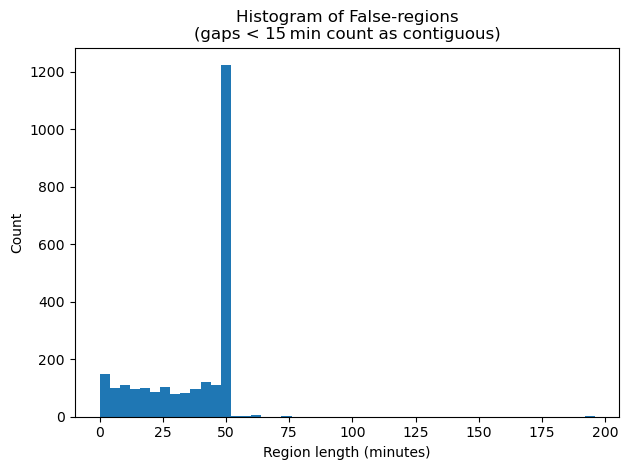

count    2469.000000
mean       36.711558
std        17.318687
min         0.000000
25%        22.976167
50%        47.966817
75%        50.015267
max       195.771417
Name: duration, dtype: float64


In [23]:
dur = plot_false_region_histogram(
    earthOccult,
    col="Fornax-AVis",
    threshold_minutes=15,
    unit="minutes",
    bins="auto"
)
print(dur.describe())

In [23]:
dirname = 'occultationResultsUpperV5min'
os.makedirs(dirname, exist_ok=True)

In [ ]:
for planet in planets:
    earthOccult[f'{planet}Angle'] = rae.solarSystemAngles(earthOccult, planet)
    earthOccult[f'{planet}Vis'] = rae.isVisible(earthOccult, earthOccult[f'{planet}Angle'])
    
    stats = rae.occultationStatisticsSigma(earthOccult, f'{planet}Vis', n=5,window=pd.Timedelta(minutes=2),antenn='rv1_coarse')

    # Save stats as a pickle file
    filename = f"{dirname}/{planet}medians.pkl"
    with open(filename, 'wb') as f:  # 'wb' for writing binary
        pickle.dump(stats, f)

In [24]:
for source_name, coord in sources.items():
    sourceAngle = [coord.ra, coord.dec]
    
    earthOccult[f'{source_name}Angle'] = rae.raeAngFromSource(earthOccult,sourceAngle)
    earthOccult[f'{source_name}Vis'] = rae.isVisible(earthOccult, earthOccult[f'{source_name}Angle'])

    stats = rae.occultationStatisticsSigma(earthOccult, f'{source_name}Vis', n=5,window=pd.Timedelta(minutes=5),antenn='rv1_coarse')

    # Save stats as a pickle file
    filename = f"{dirname}/{source_name}medians.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(stats, f)

/global/u2/a/afahs/RAE2/RAEAnglesUtilities.py:134: RuntimeWarning: invalid value encountered in divide
  dec = np.arcsin(z / r)
/global/u2/a/afahs/RAE2/RAEAnglesUtilities.py:160: RuntimeWarning: divide by zero encountered in divide
  moonWidth = np.degrees(np.tan(moonRad/moonDist))
/global/u2/a/afahs/RAE2/RAEAnglesUtilities.py:160: RuntimeWarning: invalid value encountered in tan
  moonWidth = np.degrees(np.tan(moonRad/moonDist))


  0%|          | 0/9 [00:00<?, ?it/s]

Skipping empty occultation period: 1974-01-23 00:50:17.438000 to 1974-01-23 01:49:21.665000


/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/global/homes/a/afahs/.conda/envs/maps/lib/python3.13/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NaN detected in non-occulted period
0
1974-05-16 23:33:37.274000
1974-05-16 23:59:24.732000
Skipping empty occultation period: 1974-05-26 19:15:26.333000 to 1974-05-27 01:45:50.839000
Skipping empty occultation period: 1974-06-05 00:48:25.807000 to 1974-06-05 02:41:50.191000
NaN detected in non-occulted period
0
1974-07-05 21:10:32.559000
1974-07-05 21:29:59.887000
NaN detected in non-occulted period
0
1974-07-06 18:53:32.611000
1974-07-06 20:21:05.139000
NaN detected in non-occulted period
0
1974-07-20 01:08:07.201000
1974-07-20 01:50:44.661000
Skipping empty occultation period: 1974-07-20 08:25:06.721000 to 1974-07-20 10:45:06.716000
Skipping empty occultation period: 1974-07-22 15:54:38.610000 to 1974-07-23 00:50:03.590000
NaN detected in non-occulted period
0
1974-07-30 16:45:15.791000
1974-07-30 17:06:36.428000
Skipping empty occultation period: 1974-08-03 23:54:27.017000 to 1974-08-04 00:00:02.940000
Skipping empty occultation period: 1974-09-04 23:59:57.426000 to 1974-09-05 00:0

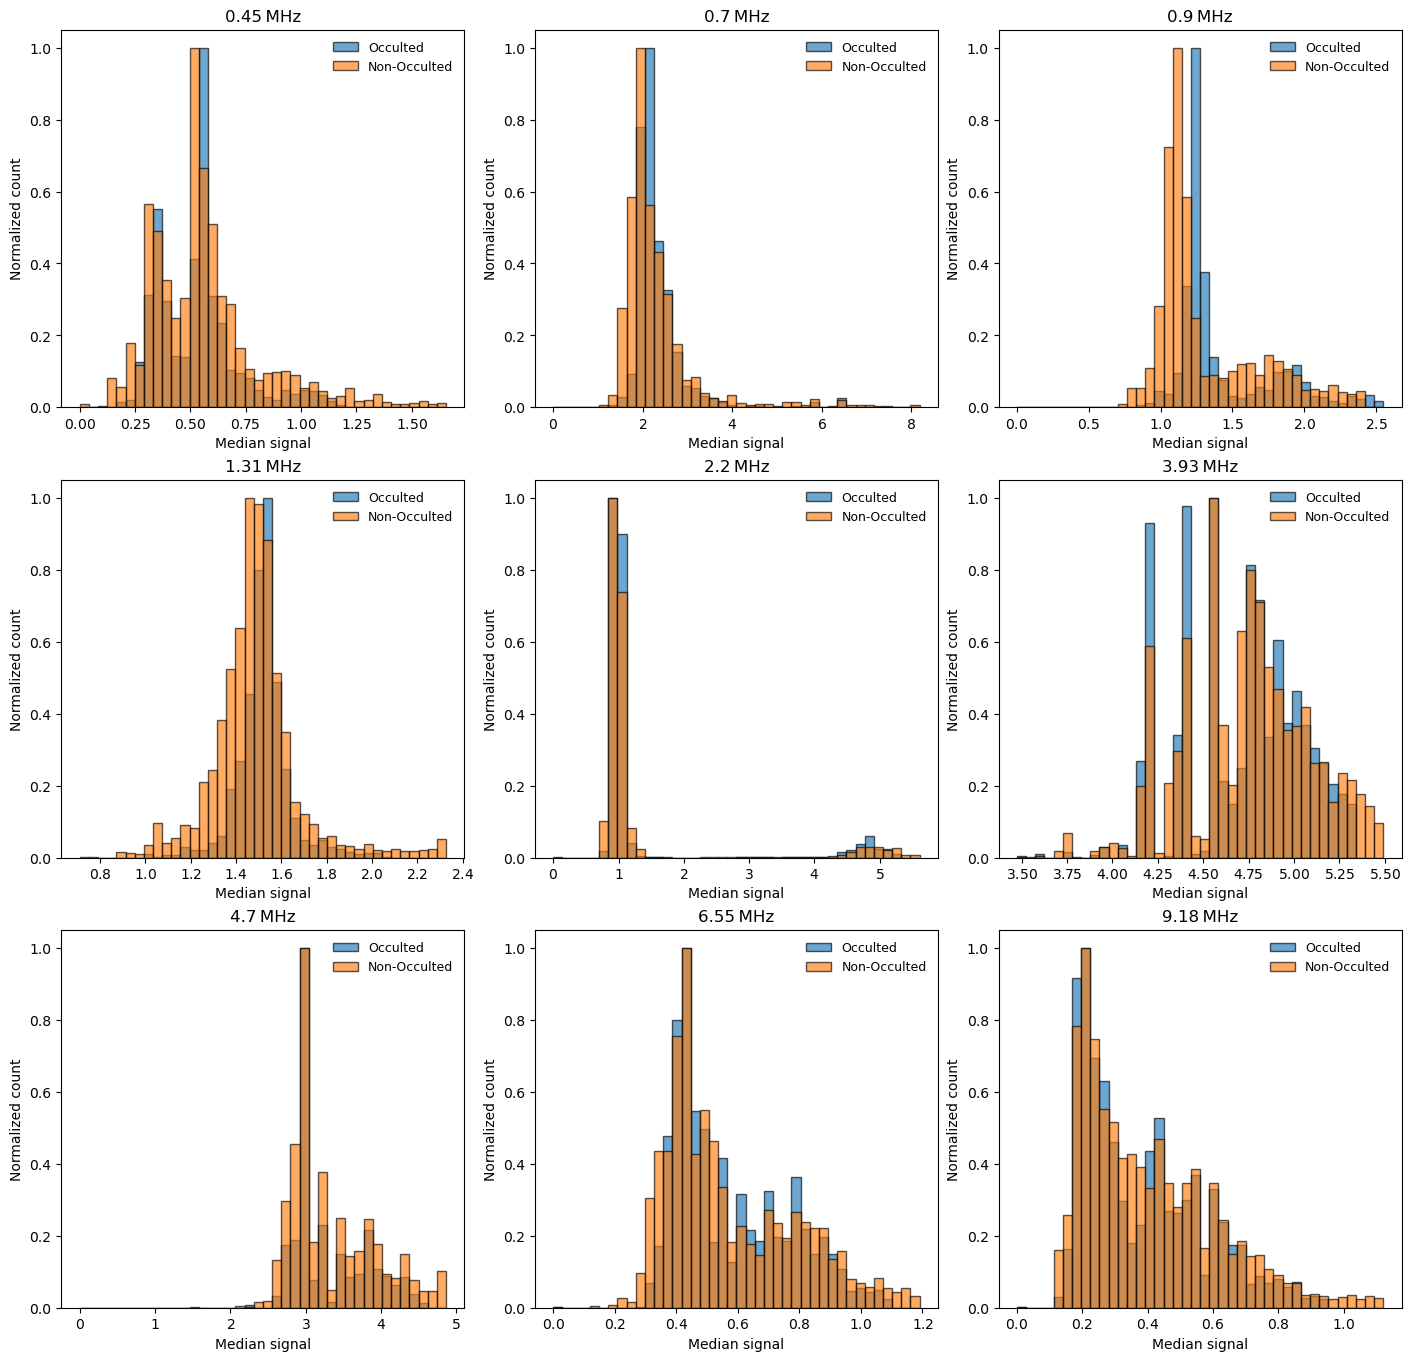

In [31]:
with open('occultationResultsLowerV2min/Sag-Amedians.pkl', "rb") as f:
        stats = pickle.load(f)
rae.plotNormalizedOccultationHistogramsPretty(stats,use_std_weights=True,apply_filter=True,min_bin_percentage=[0.5,0.1,0.1,0.1,0.1,0.3,0.1,0.1,0.1])

In [42]:
pickle_dir = dirname

In [43]:
output_dir = os.path.join(pickle_dir, 'histograms')  # Relative path

os.makedirs(output_dir, exist_ok=True)

In [44]:
pickle_files = glob.glob(os.path.join(pickle_dir, "*.pkl"))

In [45]:
pickle_files

['occultationResultsLowerV2min/Venusmedians.pkl',
 'occultationResultsLowerV2min/Marsmedians.pkl',
 'occultationResultsLowerV2min/Mercurymedians.pkl',
 'occultationResultsLowerV2min/Cygnus-Amedians.pkl',
 'occultationResultsLowerV2min/Neptunemedians.pkl',
 'occultationResultsLowerV2min/Saturnmedians.pkl',
 'occultationResultsLowerV2min/Sag-Amedians.pkl',
 'occultationResultsLowerV2min/Fornax-Amedians.pkl',
 'occultationResultsLowerV2min/Virgo Amedians.pkl',
 'occultationResultsLowerV2min/Tau-Amedians.pkl',
 'occultationResultsLowerV2min/CAS-Amedians.pkl',
 'occultationResultsLowerV2min/Crab Nebulamedians.pkl',
 'occultationResultsLowerV2min/Jupitermedians.pkl',
 'occultationResultsLowerV2min/Uranusmedians.pkl']

Figure saved as occultationResultsLowerV2min/histograms/Venusmedians.pdf


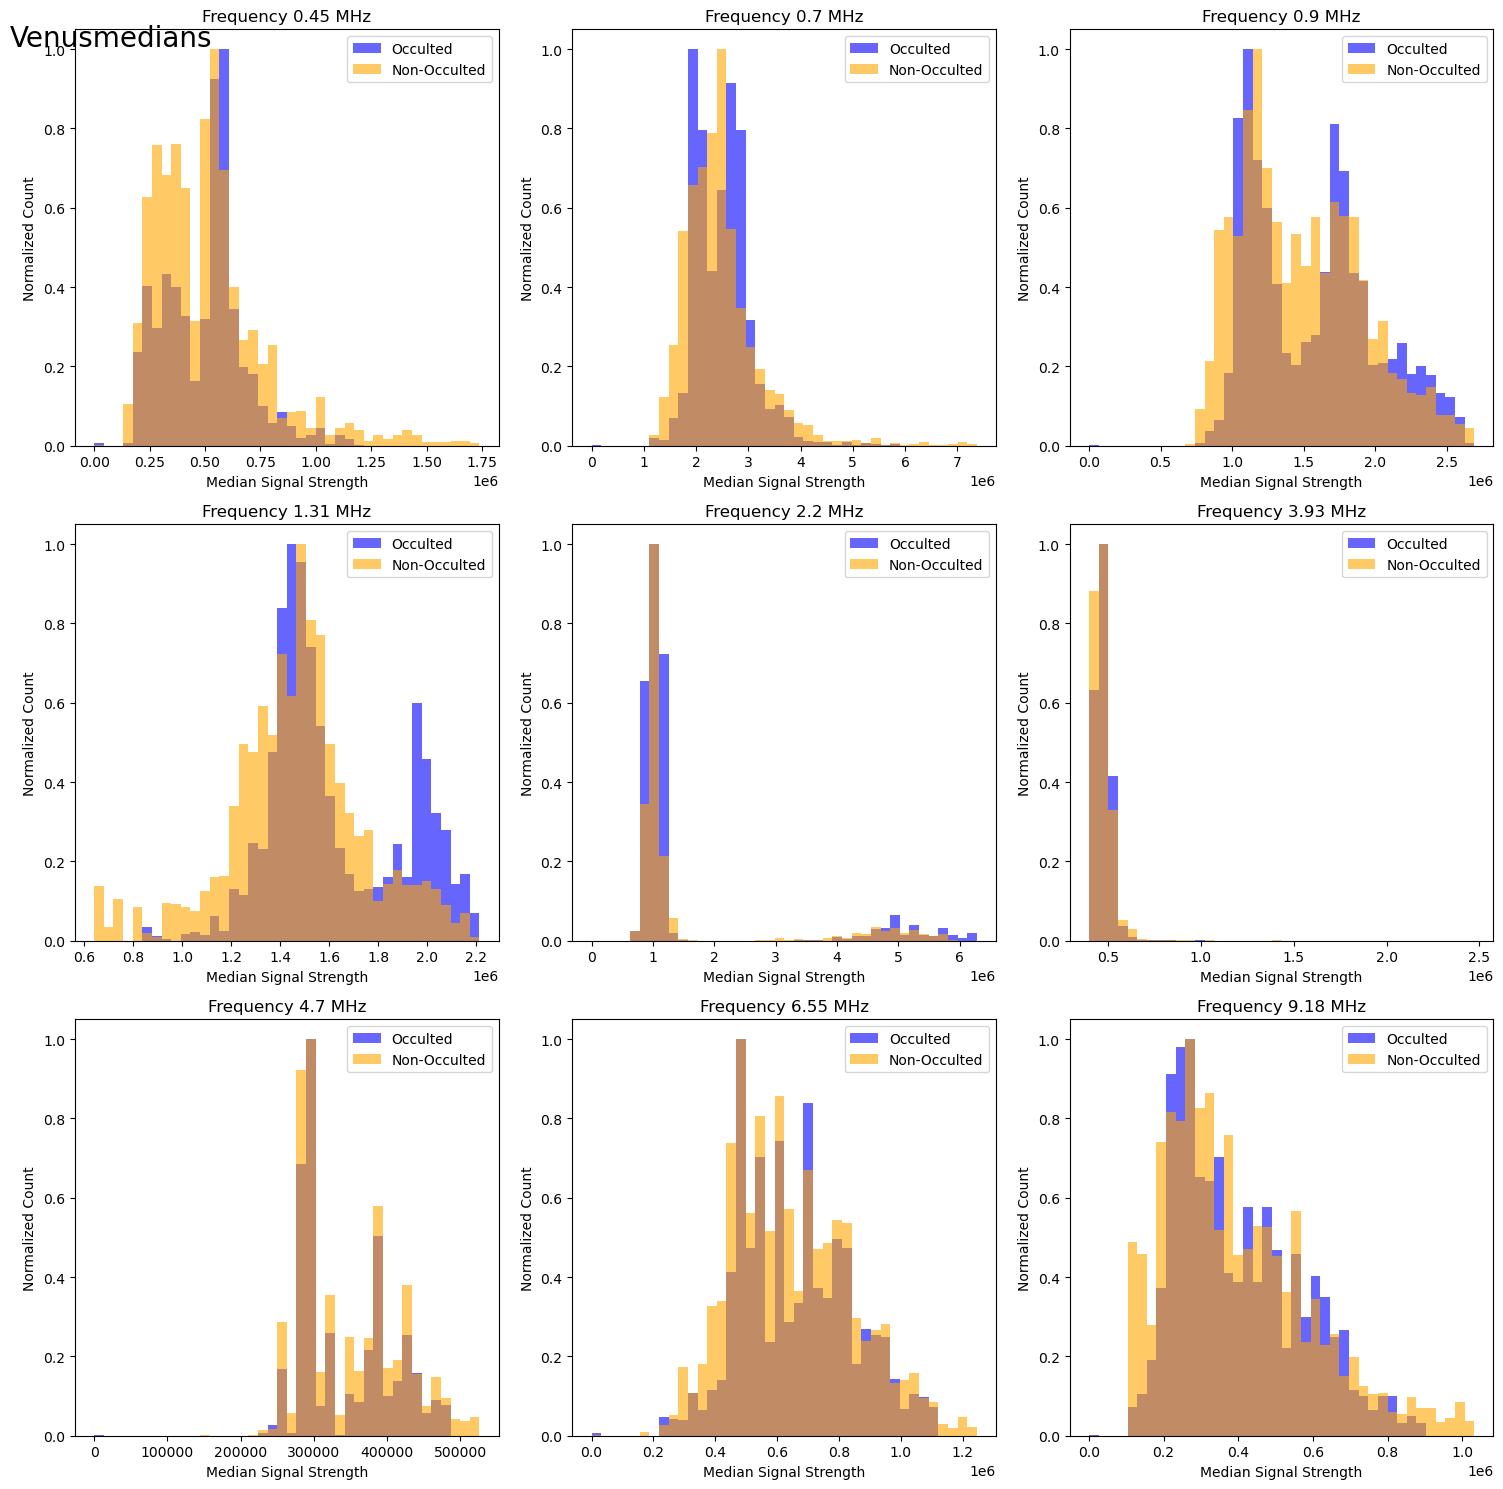

Saved histogram for Venusmedians as occultationResultsLowerV2min/histograms/Venusmedians.pdf
Figure saved as occultationResultsLowerV2min/histograms/Marsmedians.pdf


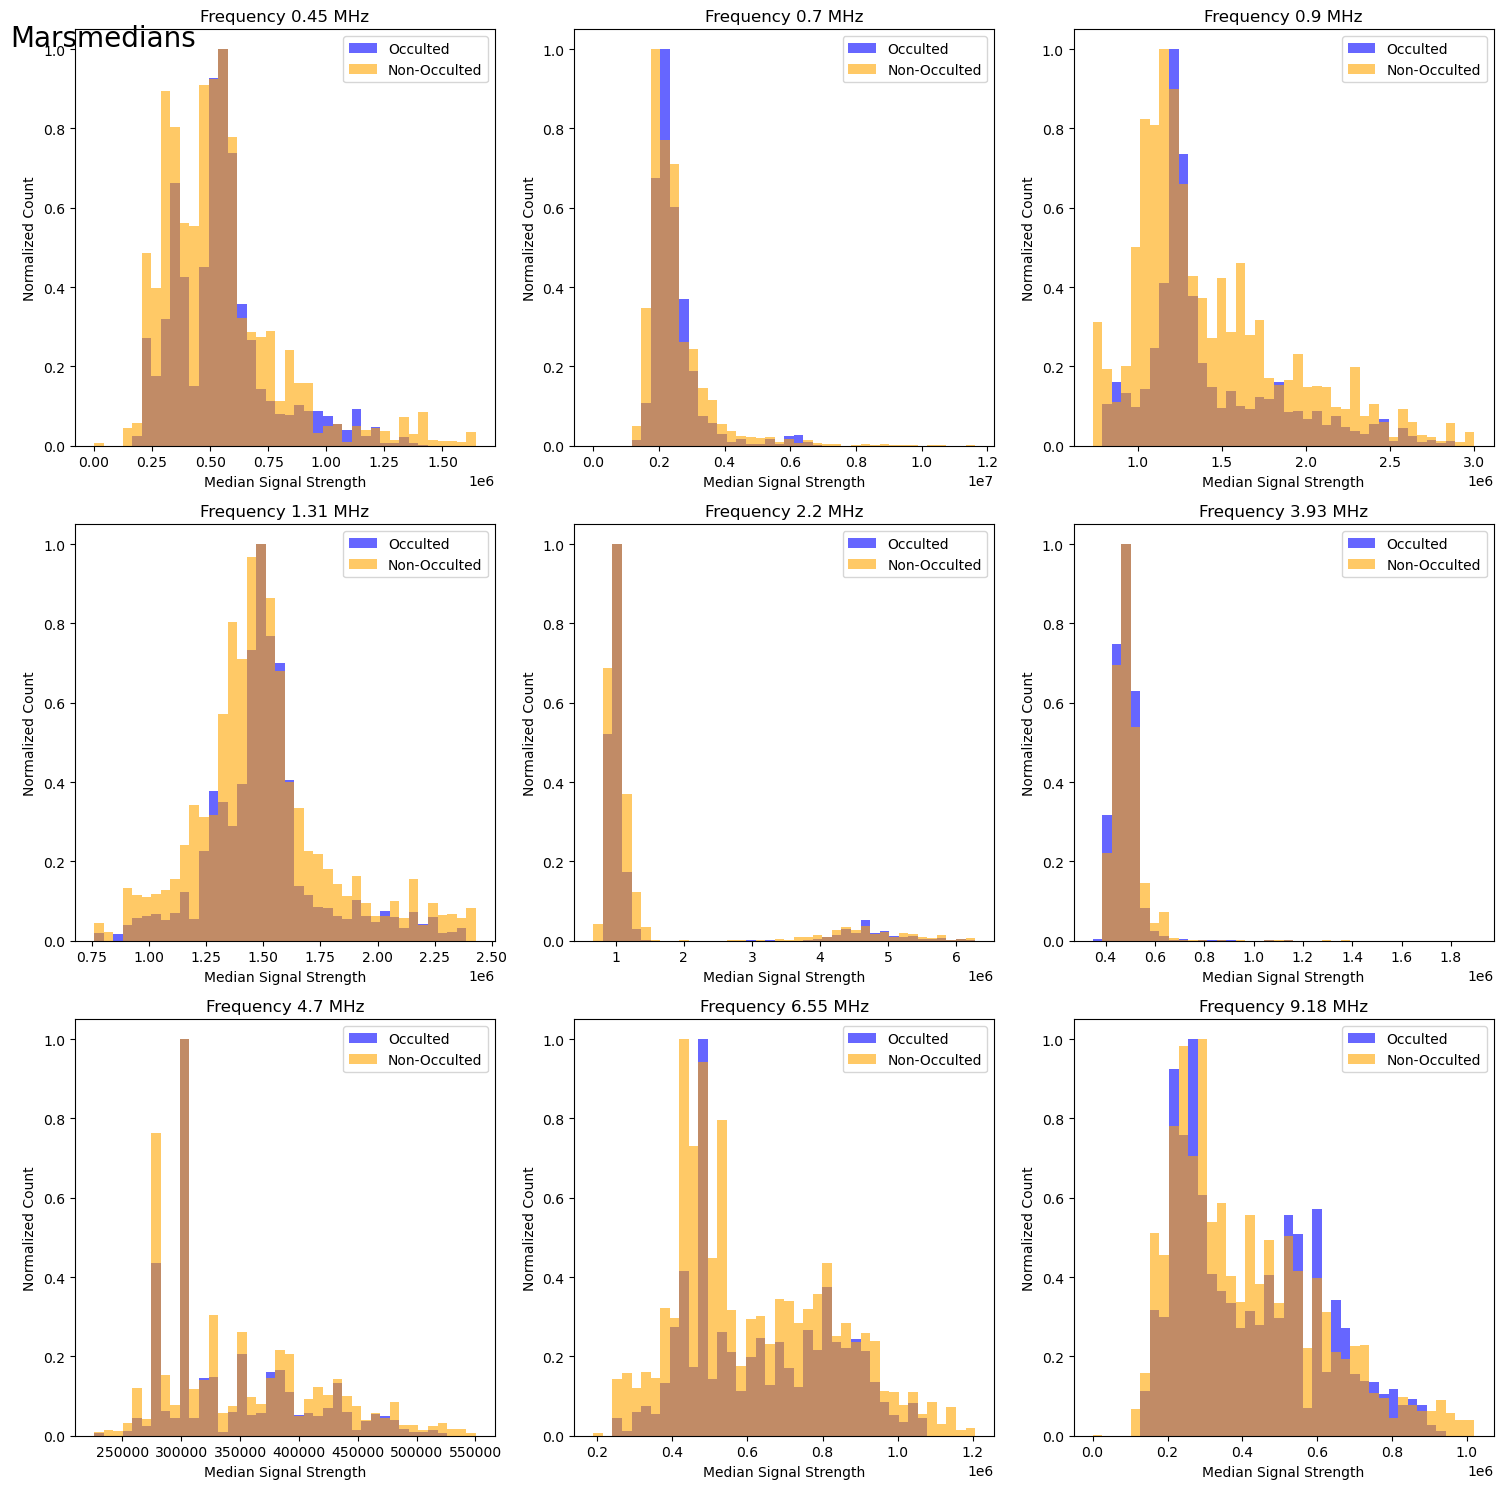

Saved histogram for Marsmedians as occultationResultsLowerV2min/histograms/Marsmedians.pdf
Figure saved as occultationResultsLowerV2min/histograms/Mercurymedians.pdf


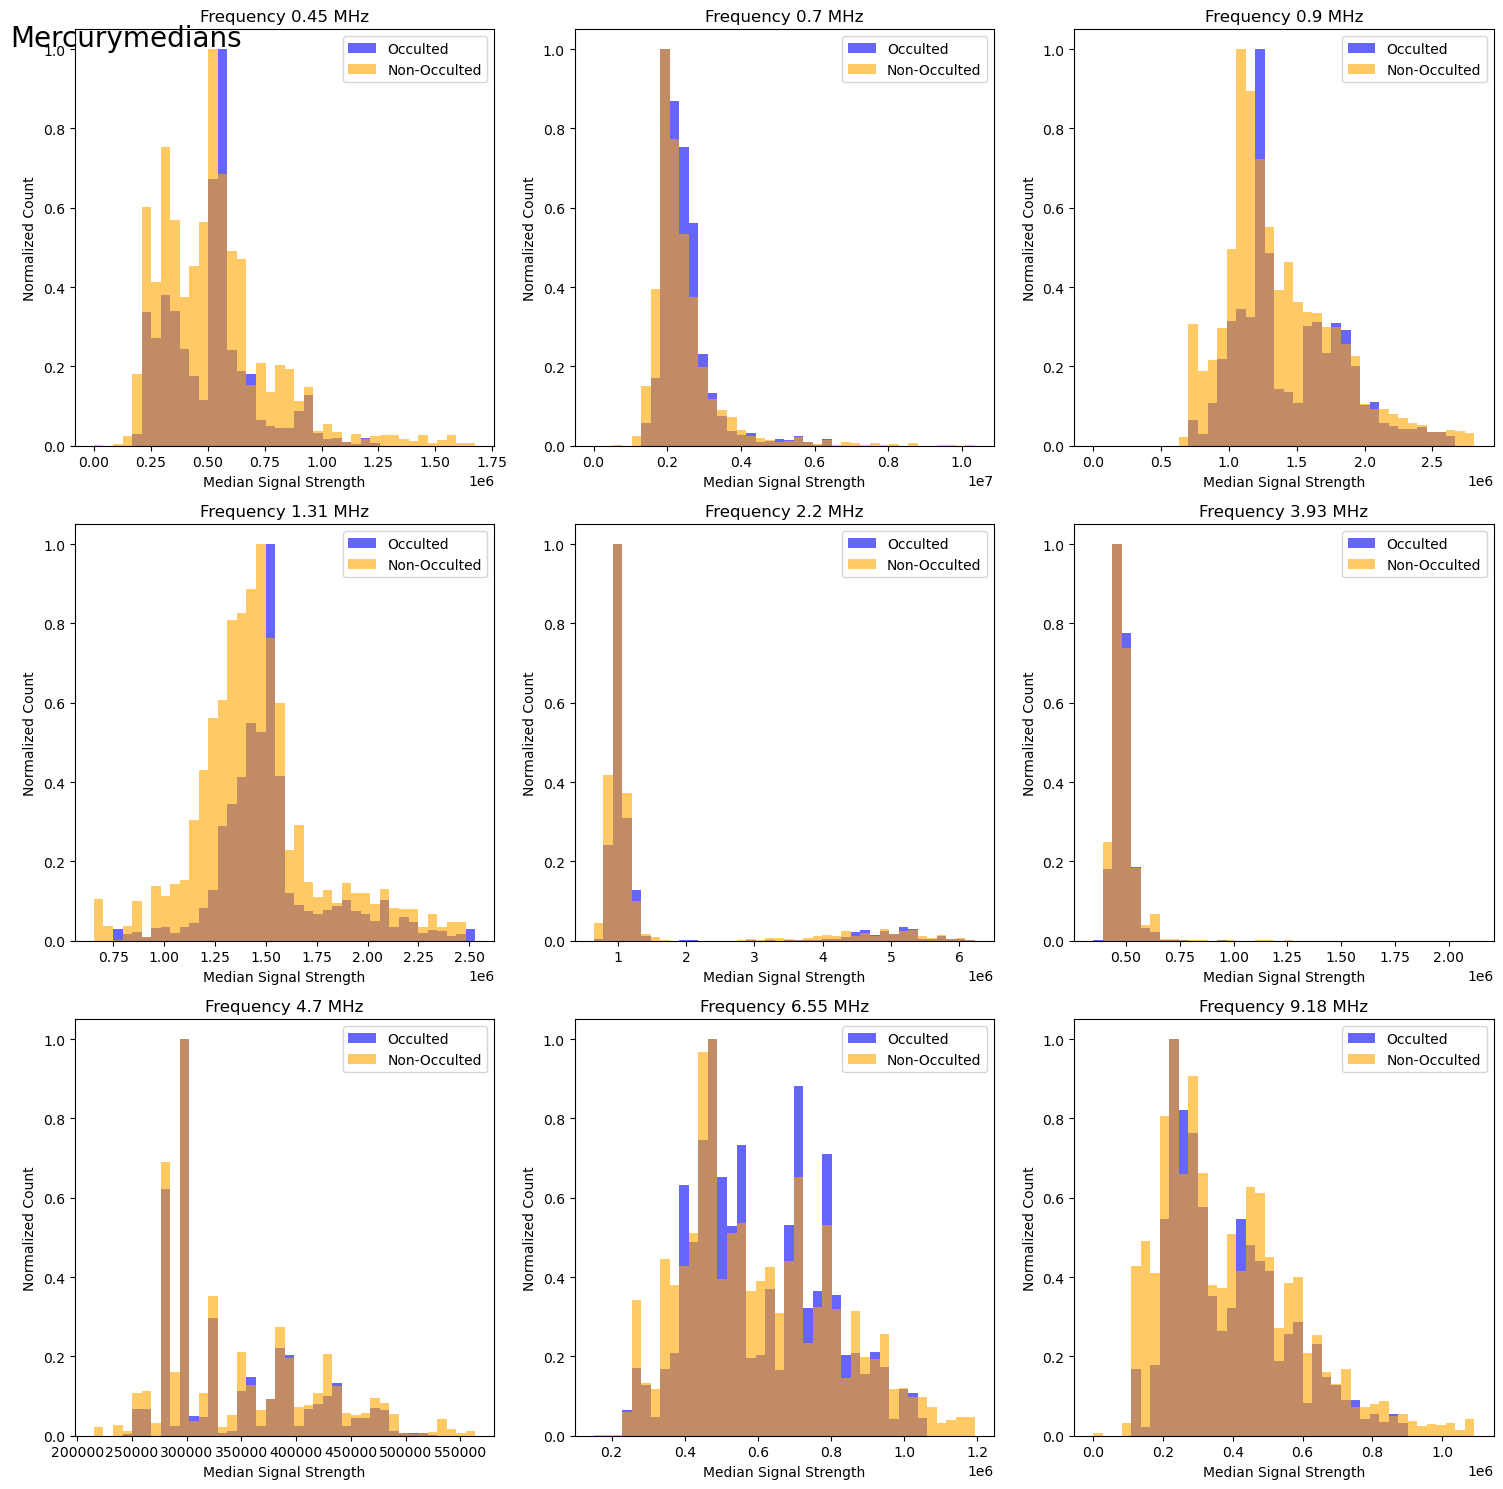

Saved histogram for Mercurymedians as occultationResultsLowerV2min/histograms/Mercurymedians.pdf
Figure saved as occultationResultsLowerV2min/histograms/Cygnus-Amedians.pdf


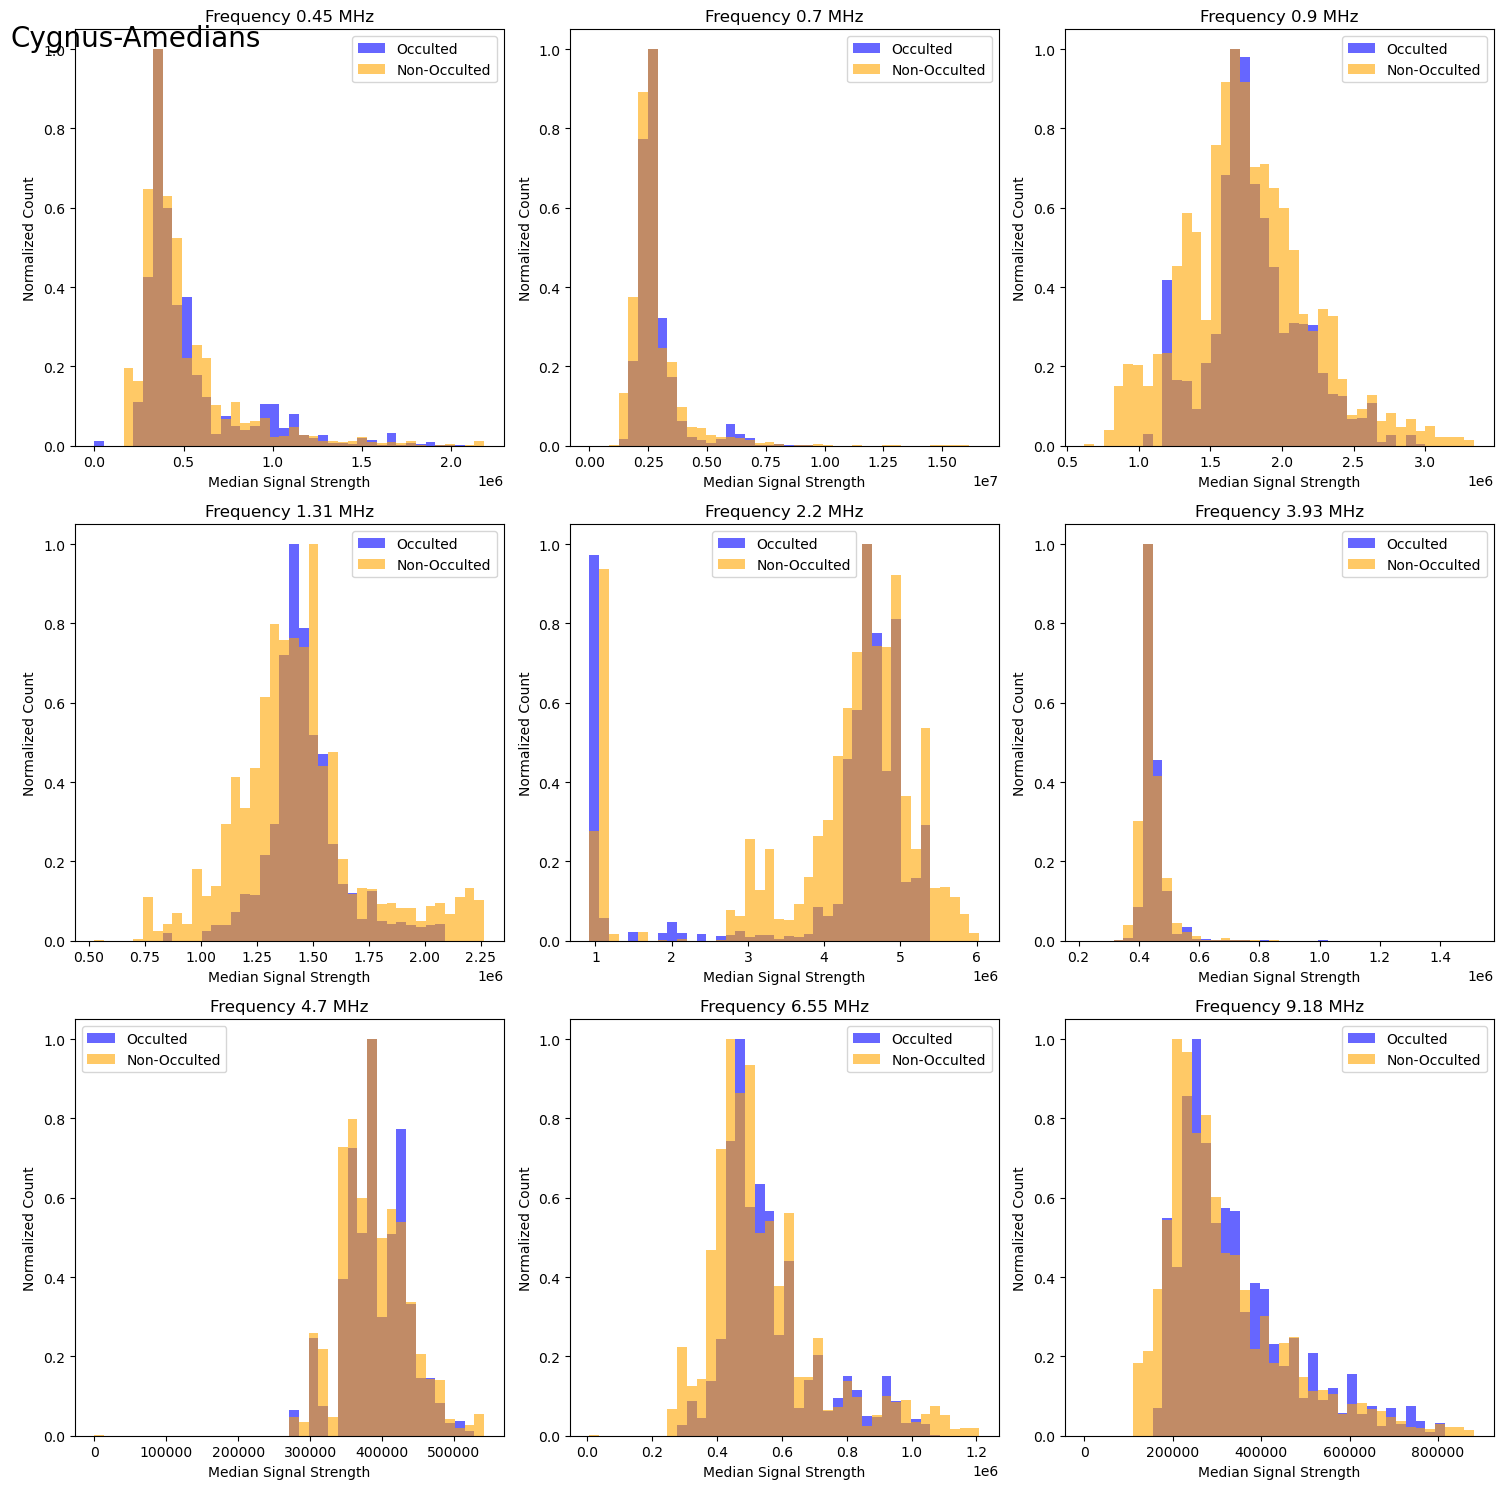

Saved histogram for Cygnus-Amedians as occultationResultsLowerV2min/histograms/Cygnus-Amedians.pdf
Figure saved as occultationResultsLowerV2min/histograms/Neptunemedians.pdf


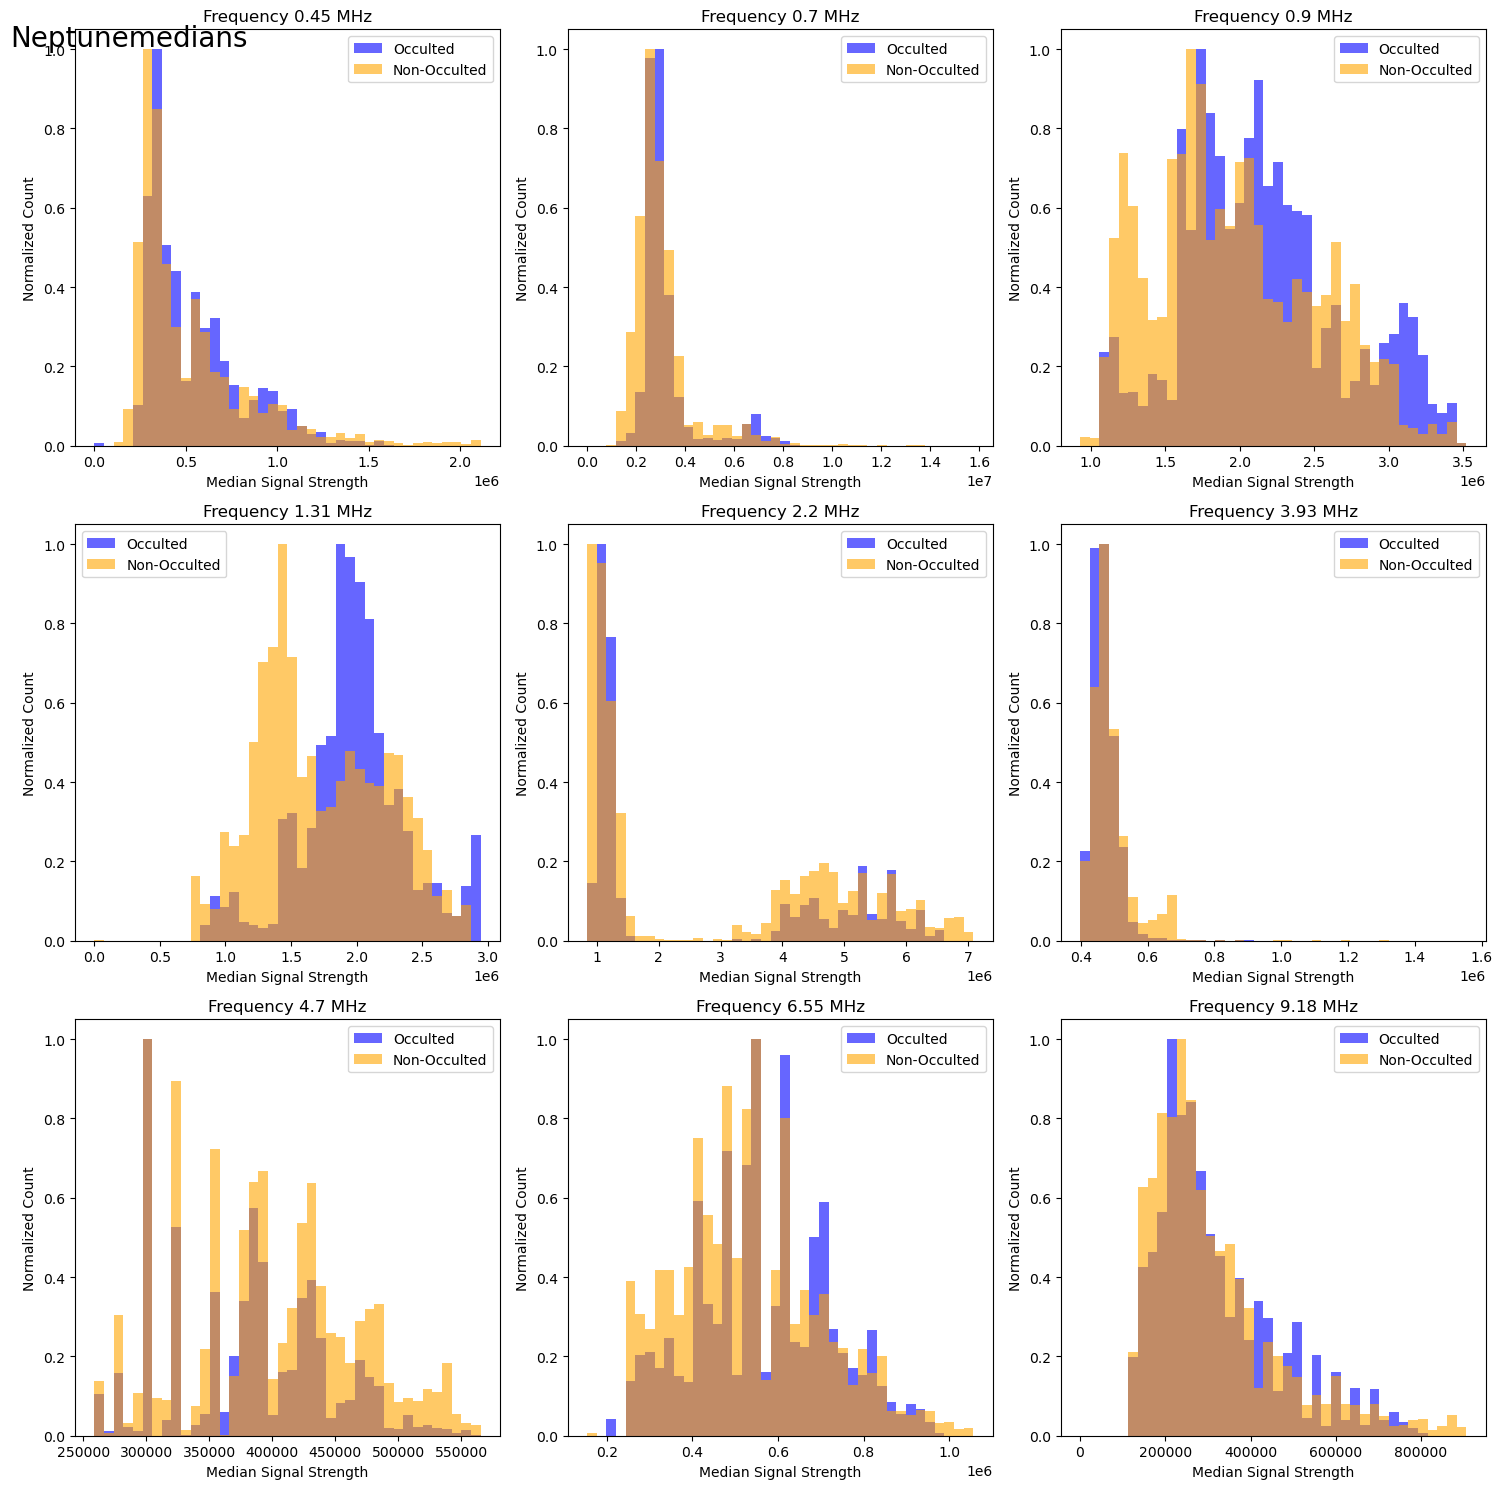

Saved histogram for Neptunemedians as occultationResultsLowerV2min/histograms/Neptunemedians.pdf
Figure saved as occultationResultsLowerV2min/histograms/Saturnmedians.pdf


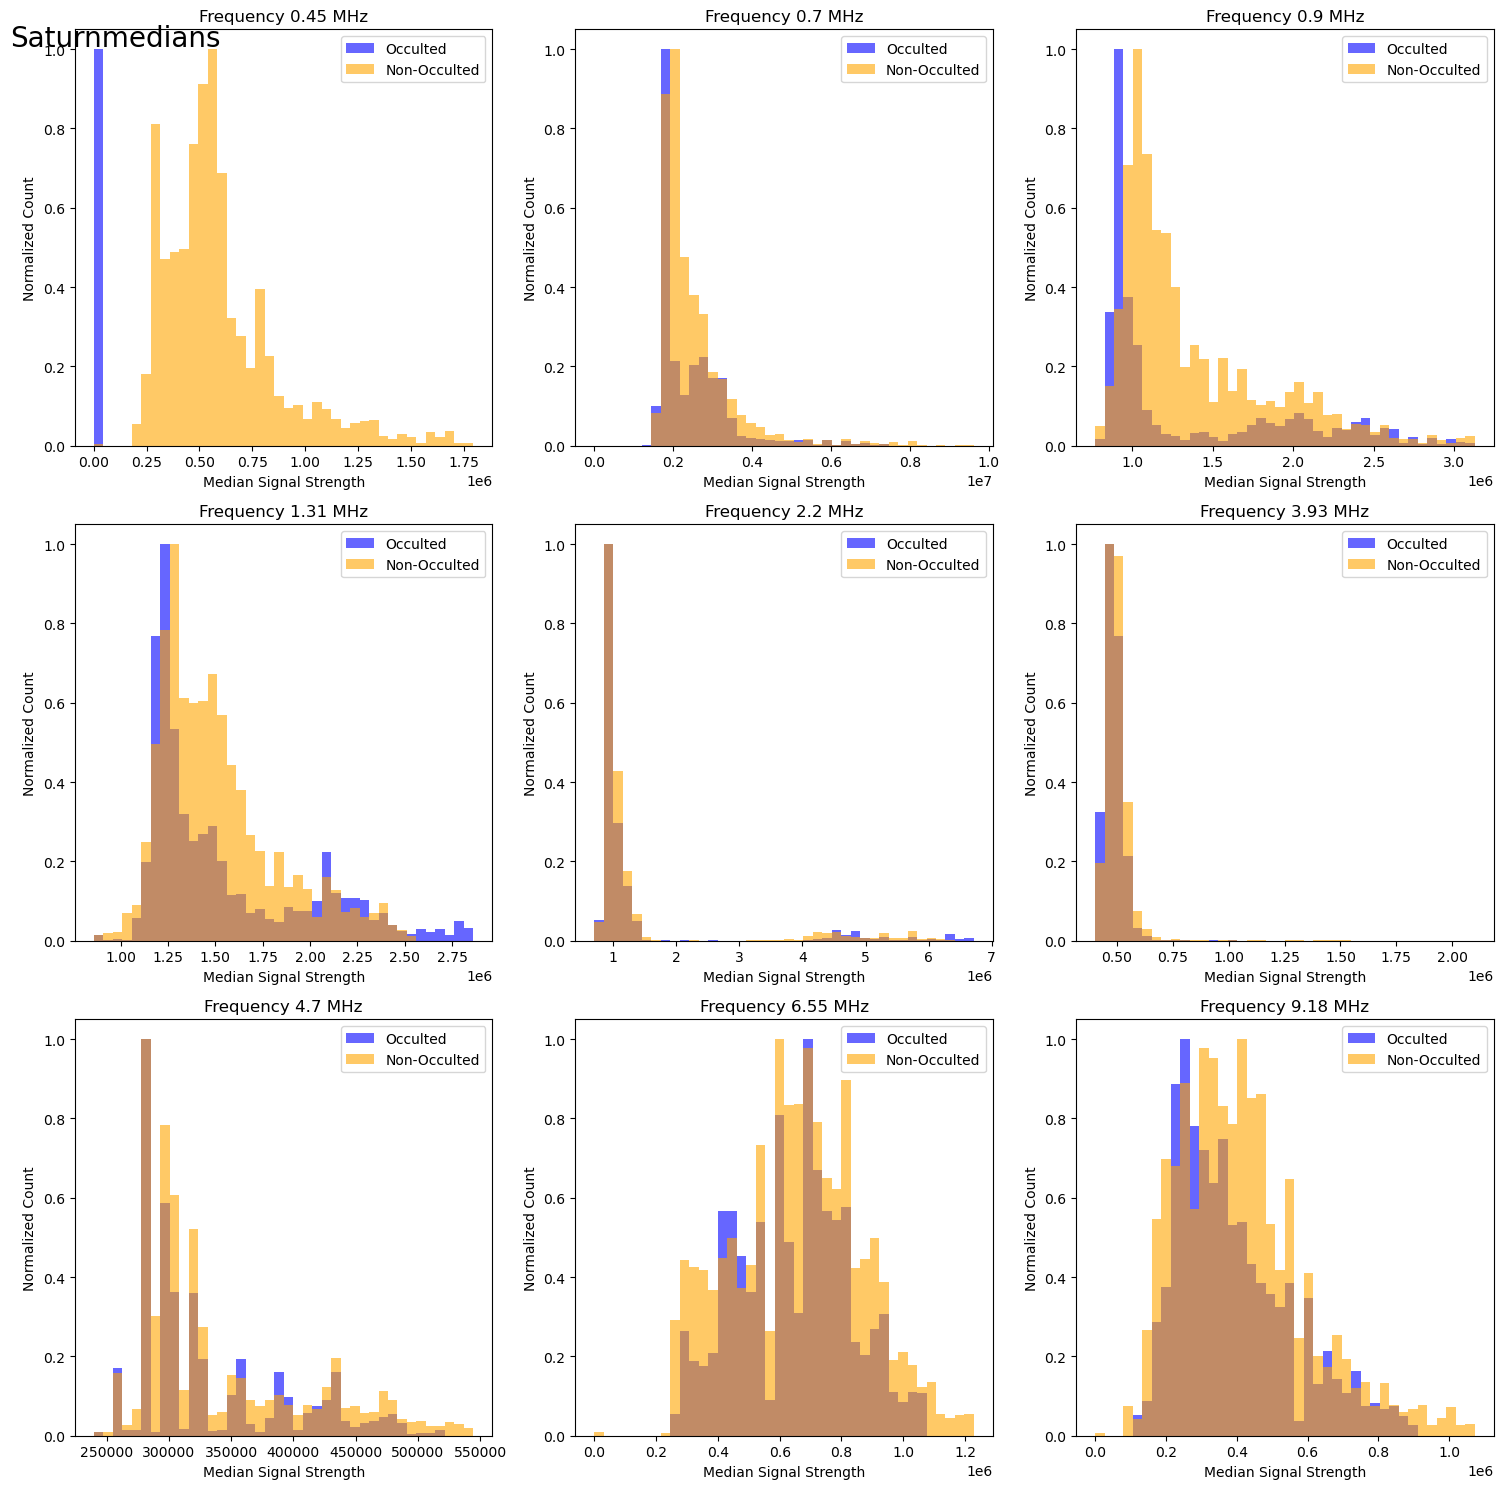

Saved histogram for Saturnmedians as occultationResultsLowerV2min/histograms/Saturnmedians.pdf
Figure saved as occultationResultsLowerV2min/histograms/Sag-Amedians.pdf


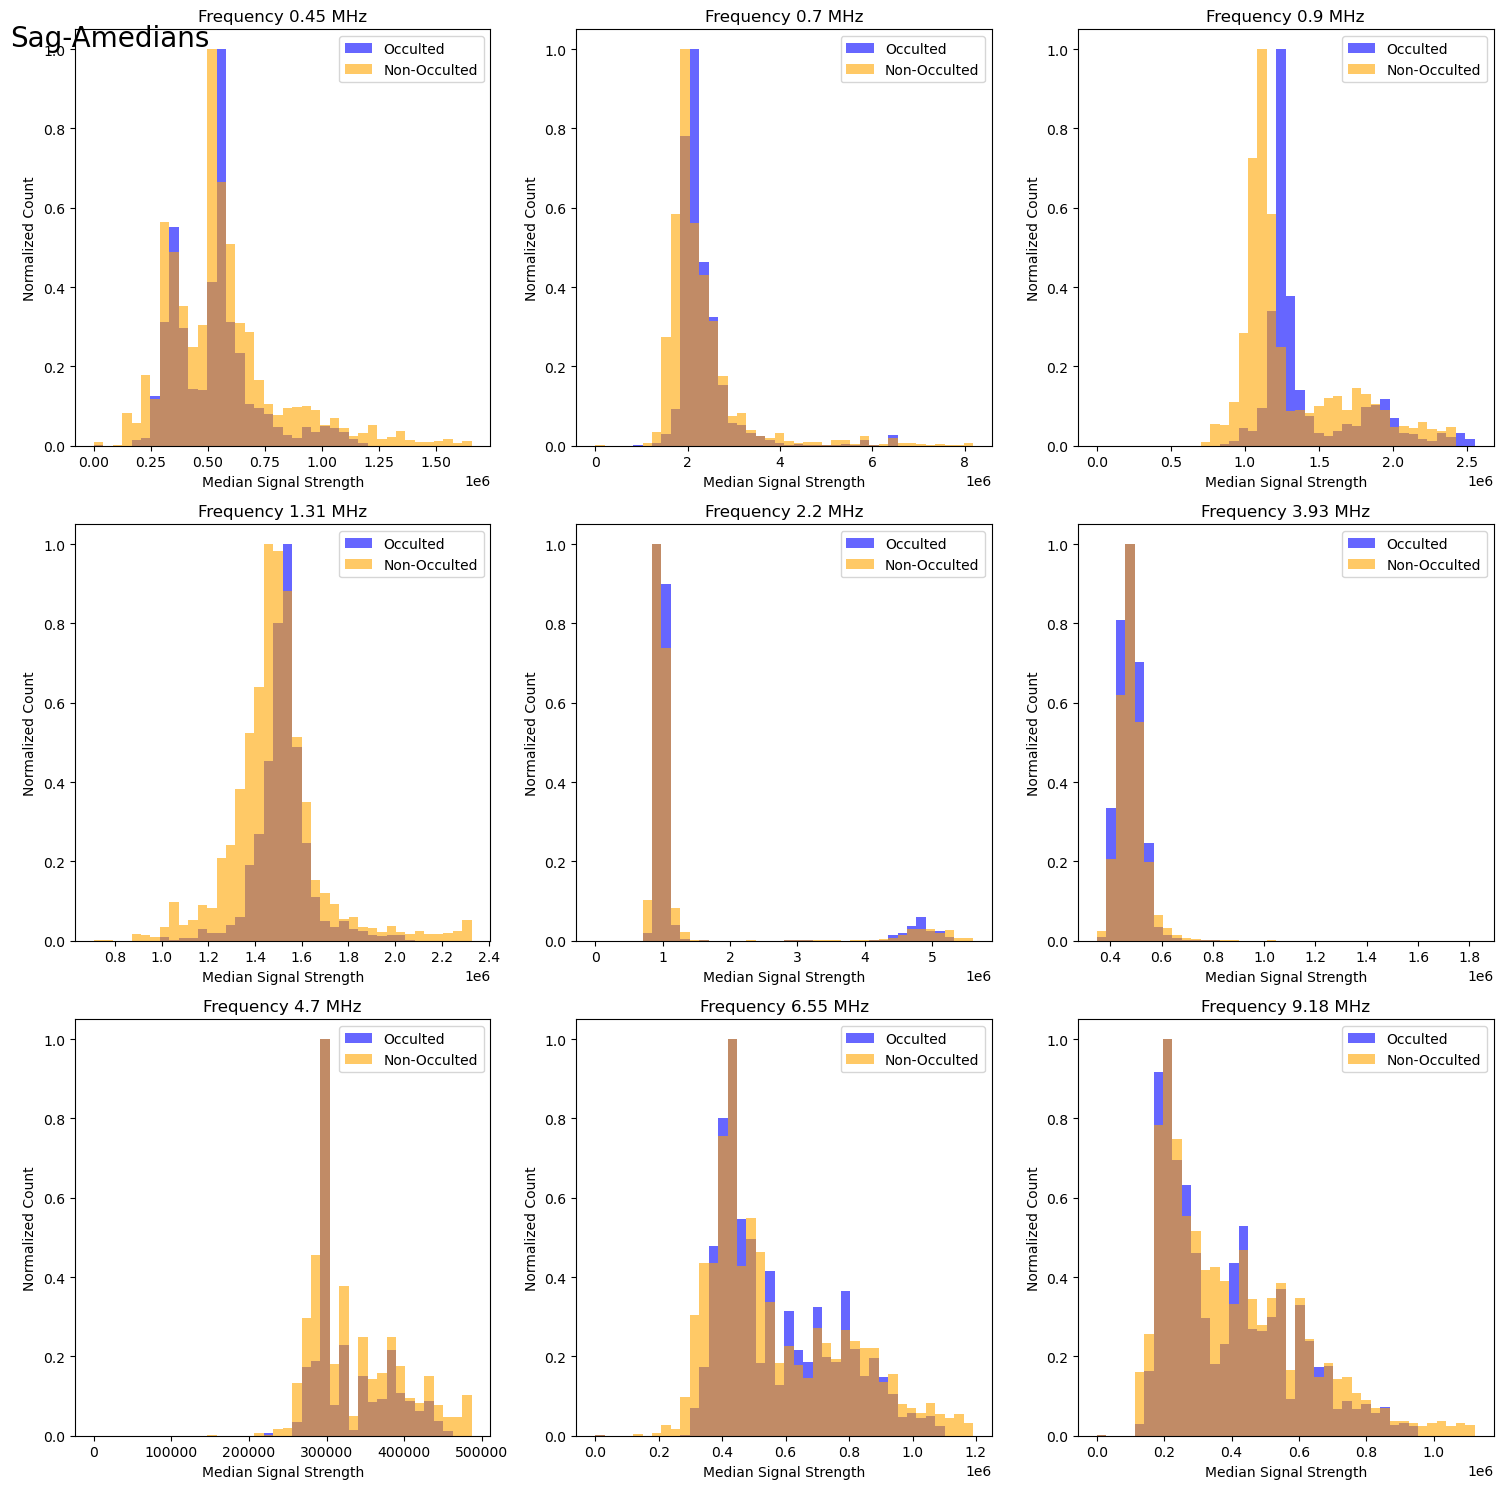

Saved histogram for Sag-Amedians as occultationResultsLowerV2min/histograms/Sag-Amedians.pdf
Figure saved as occultationResultsLowerV2min/histograms/Fornax-Amedians.pdf


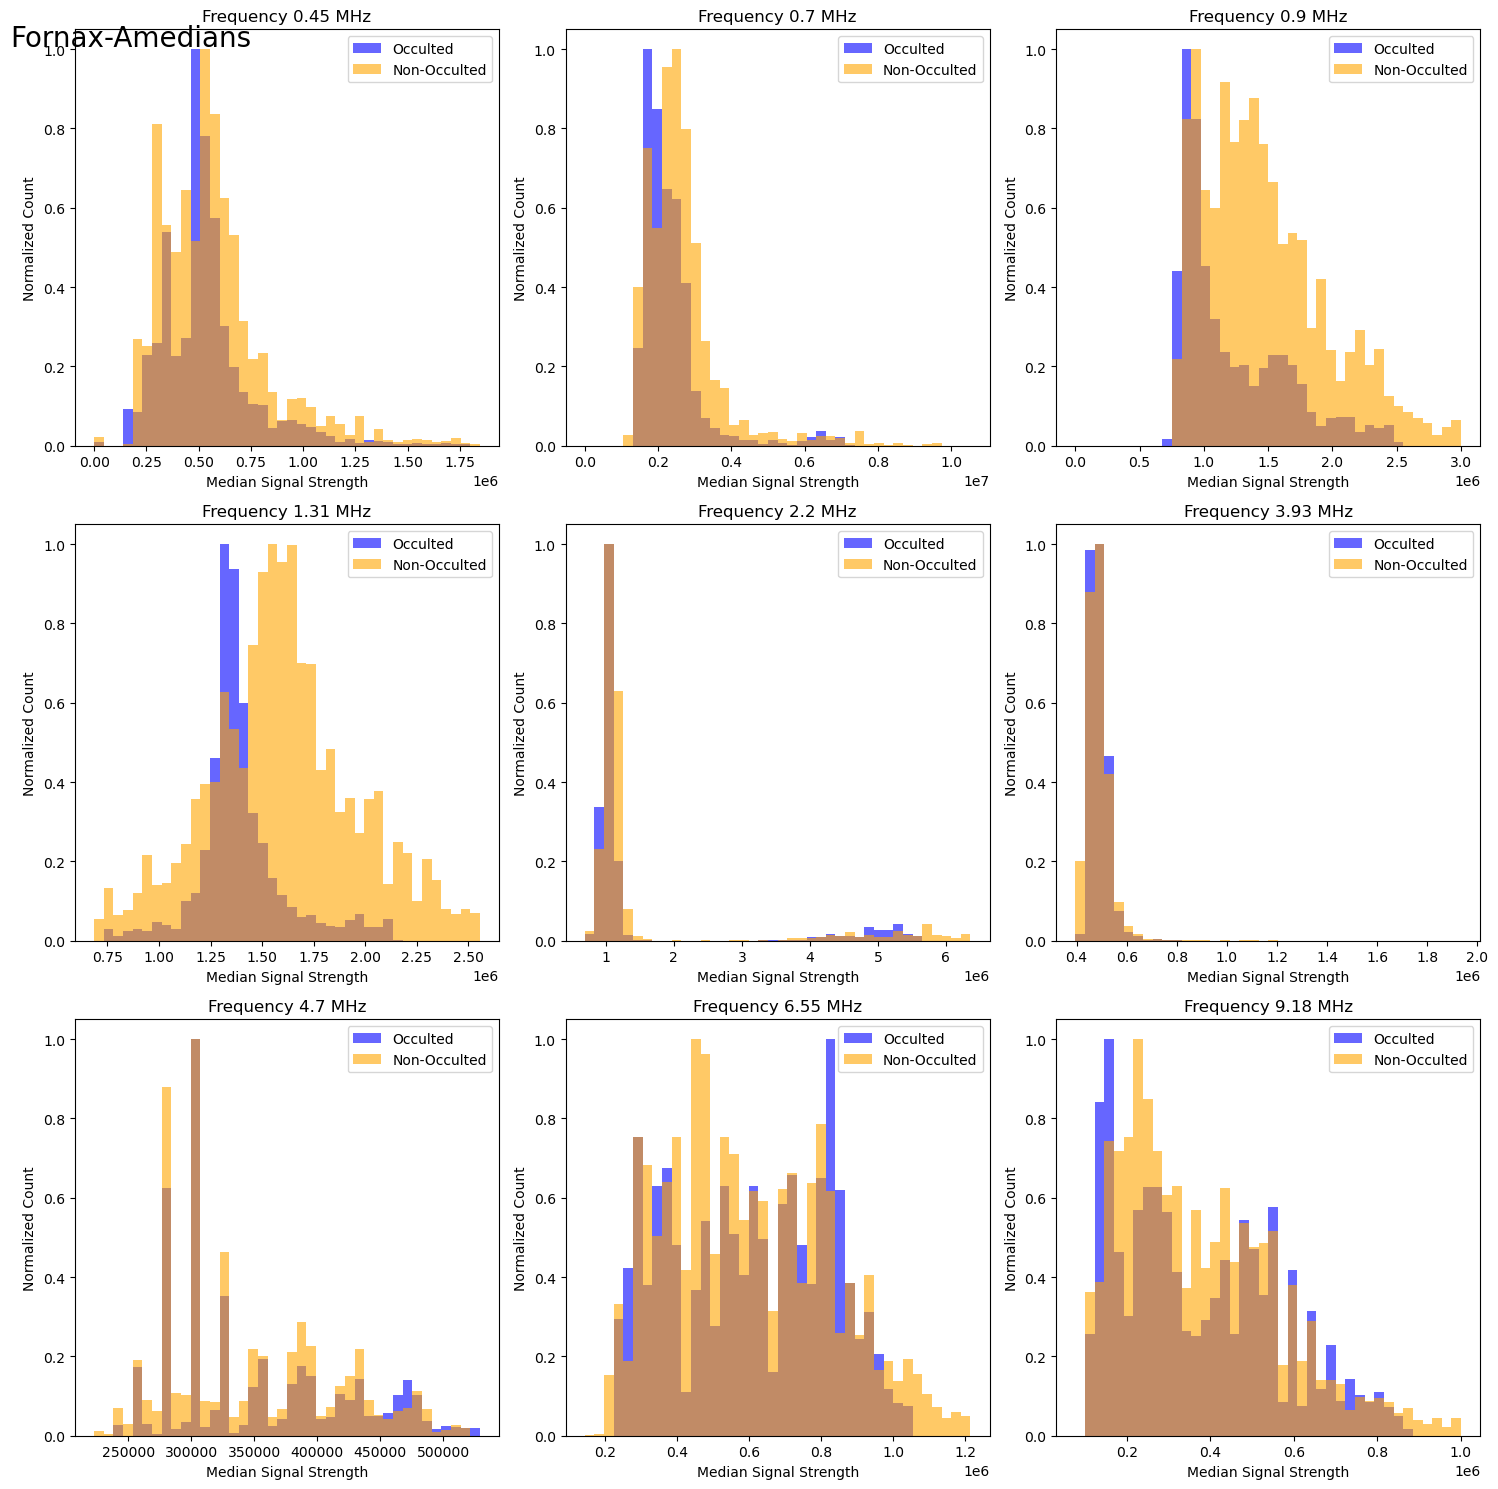

Saved histogram for Fornax-Amedians as occultationResultsLowerV2min/histograms/Fornax-Amedians.pdf
Figure saved as occultationResultsLowerV2min/histograms/Virgo Amedians.pdf


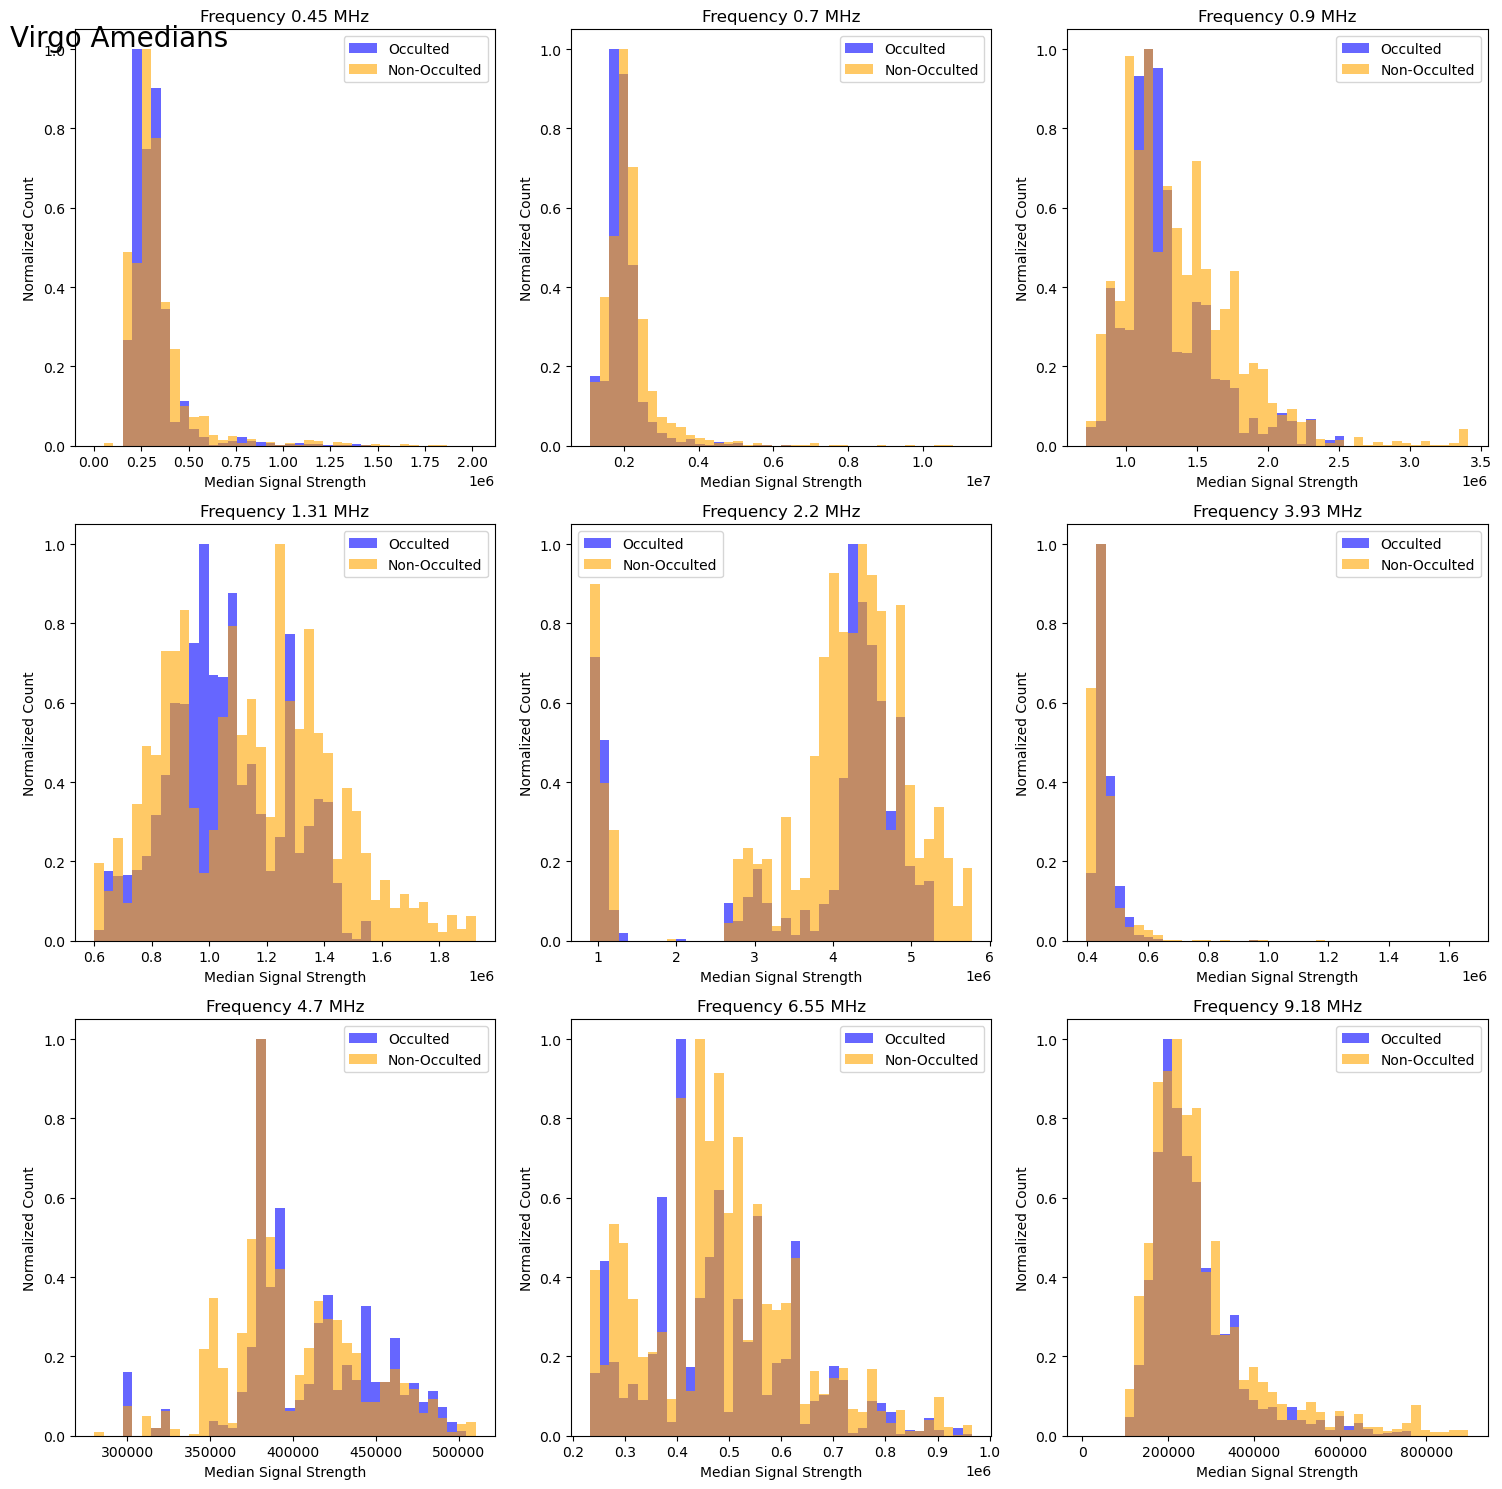

Saved histogram for Virgo Amedians as occultationResultsLowerV2min/histograms/Virgo Amedians.pdf
Figure saved as occultationResultsLowerV2min/histograms/Tau-Amedians.pdf


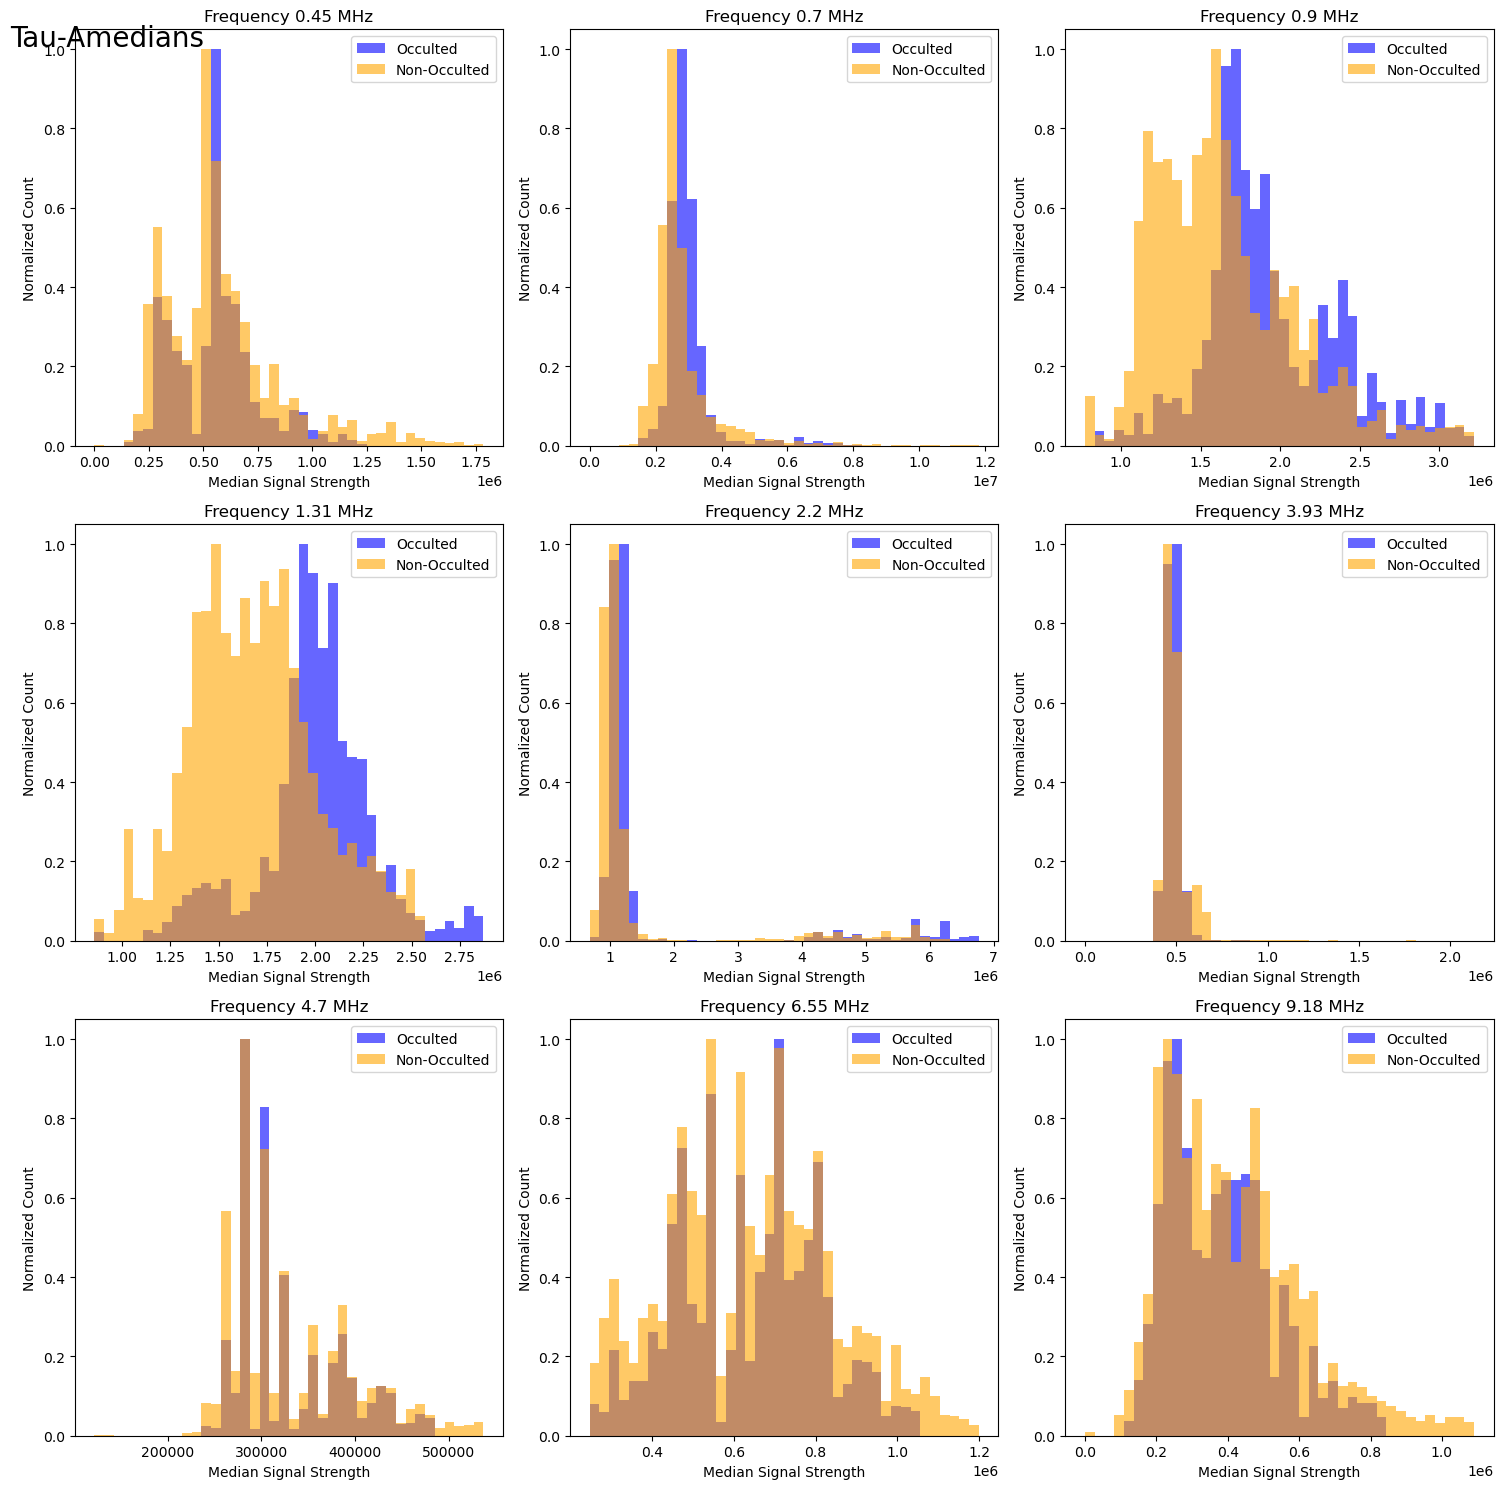

Saved histogram for Tau-Amedians as occultationResultsLowerV2min/histograms/Tau-Amedians.pdf
Figure saved as occultationResultsLowerV2min/histograms/CAS-Amedians.pdf


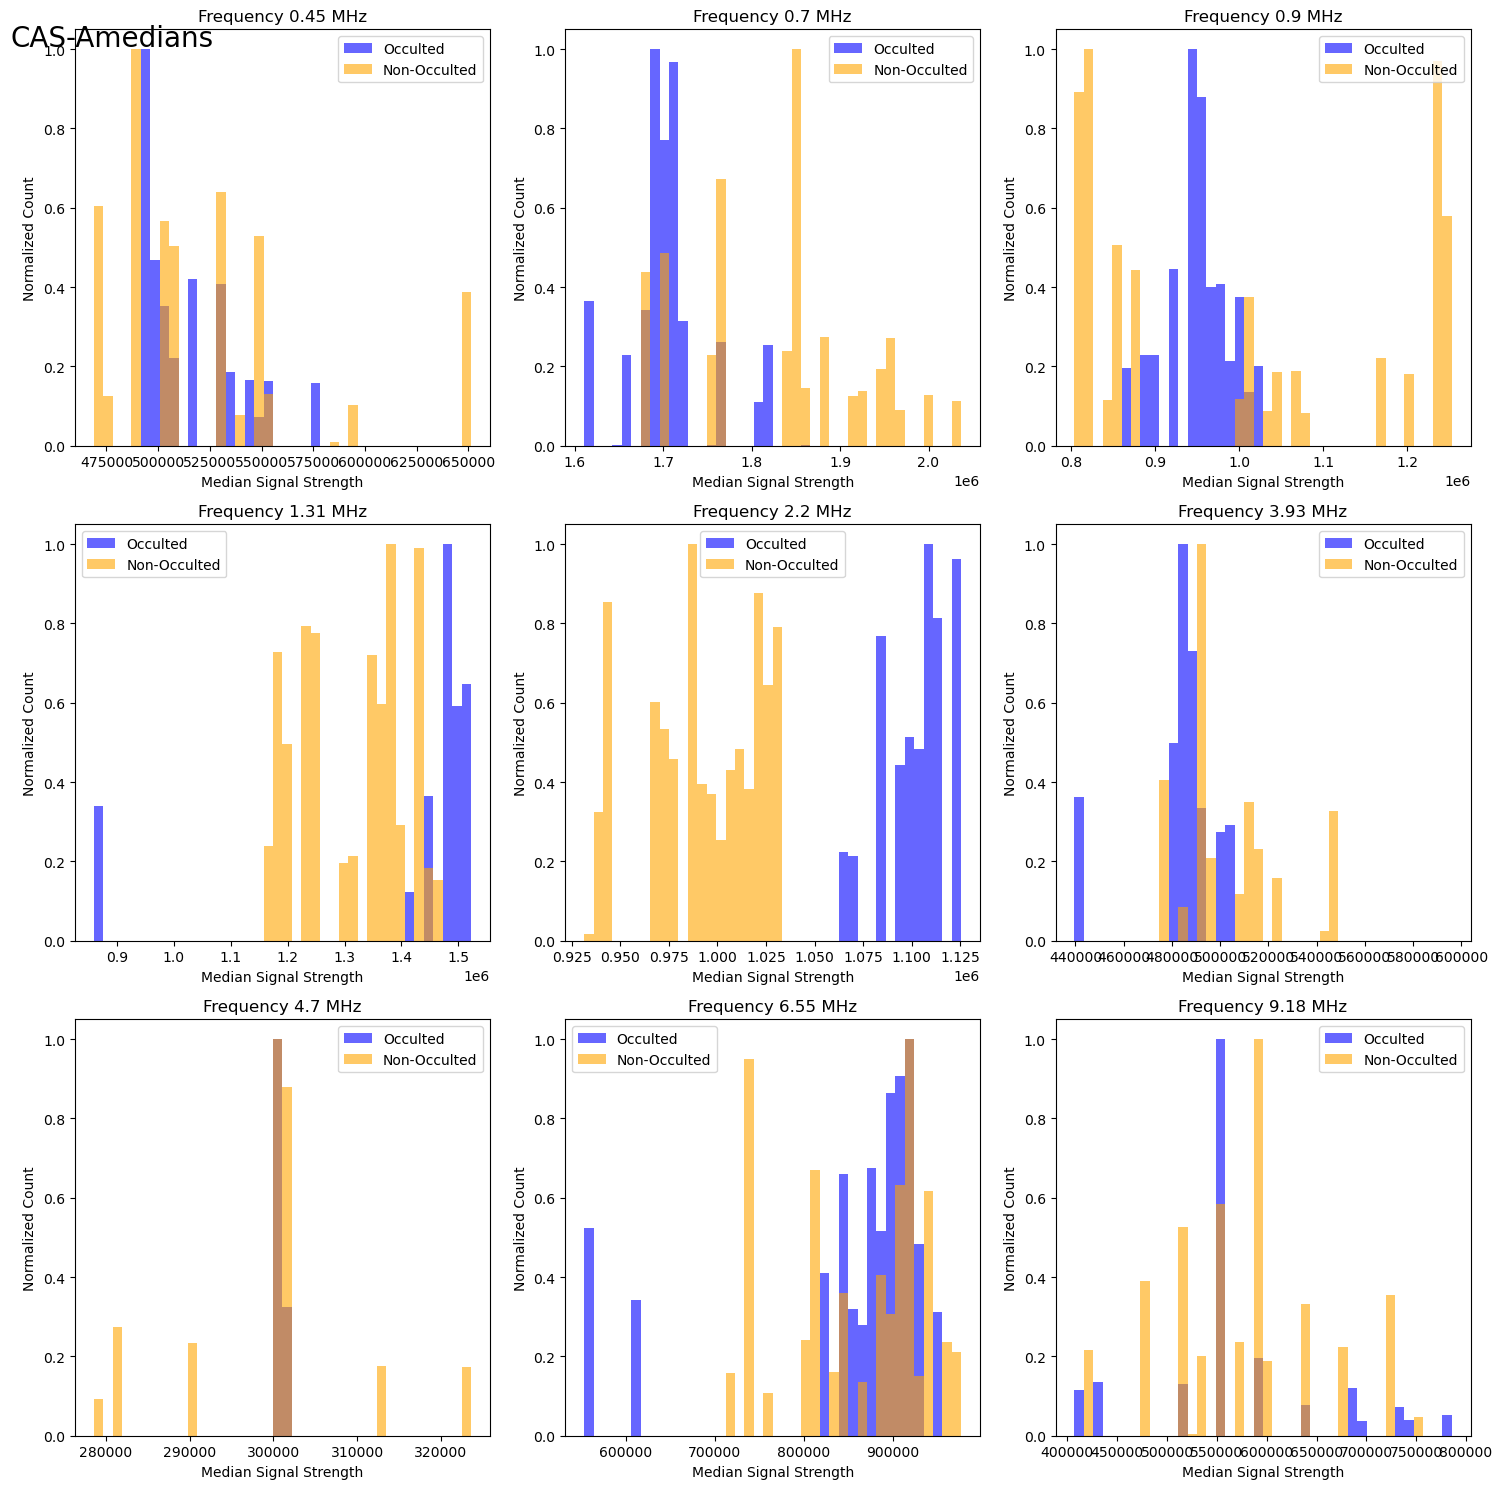

Saved histogram for CAS-Amedians as occultationResultsLowerV2min/histograms/CAS-Amedians.pdf
Figure saved as occultationResultsLowerV2min/histograms/Crab Nebulamedians.pdf


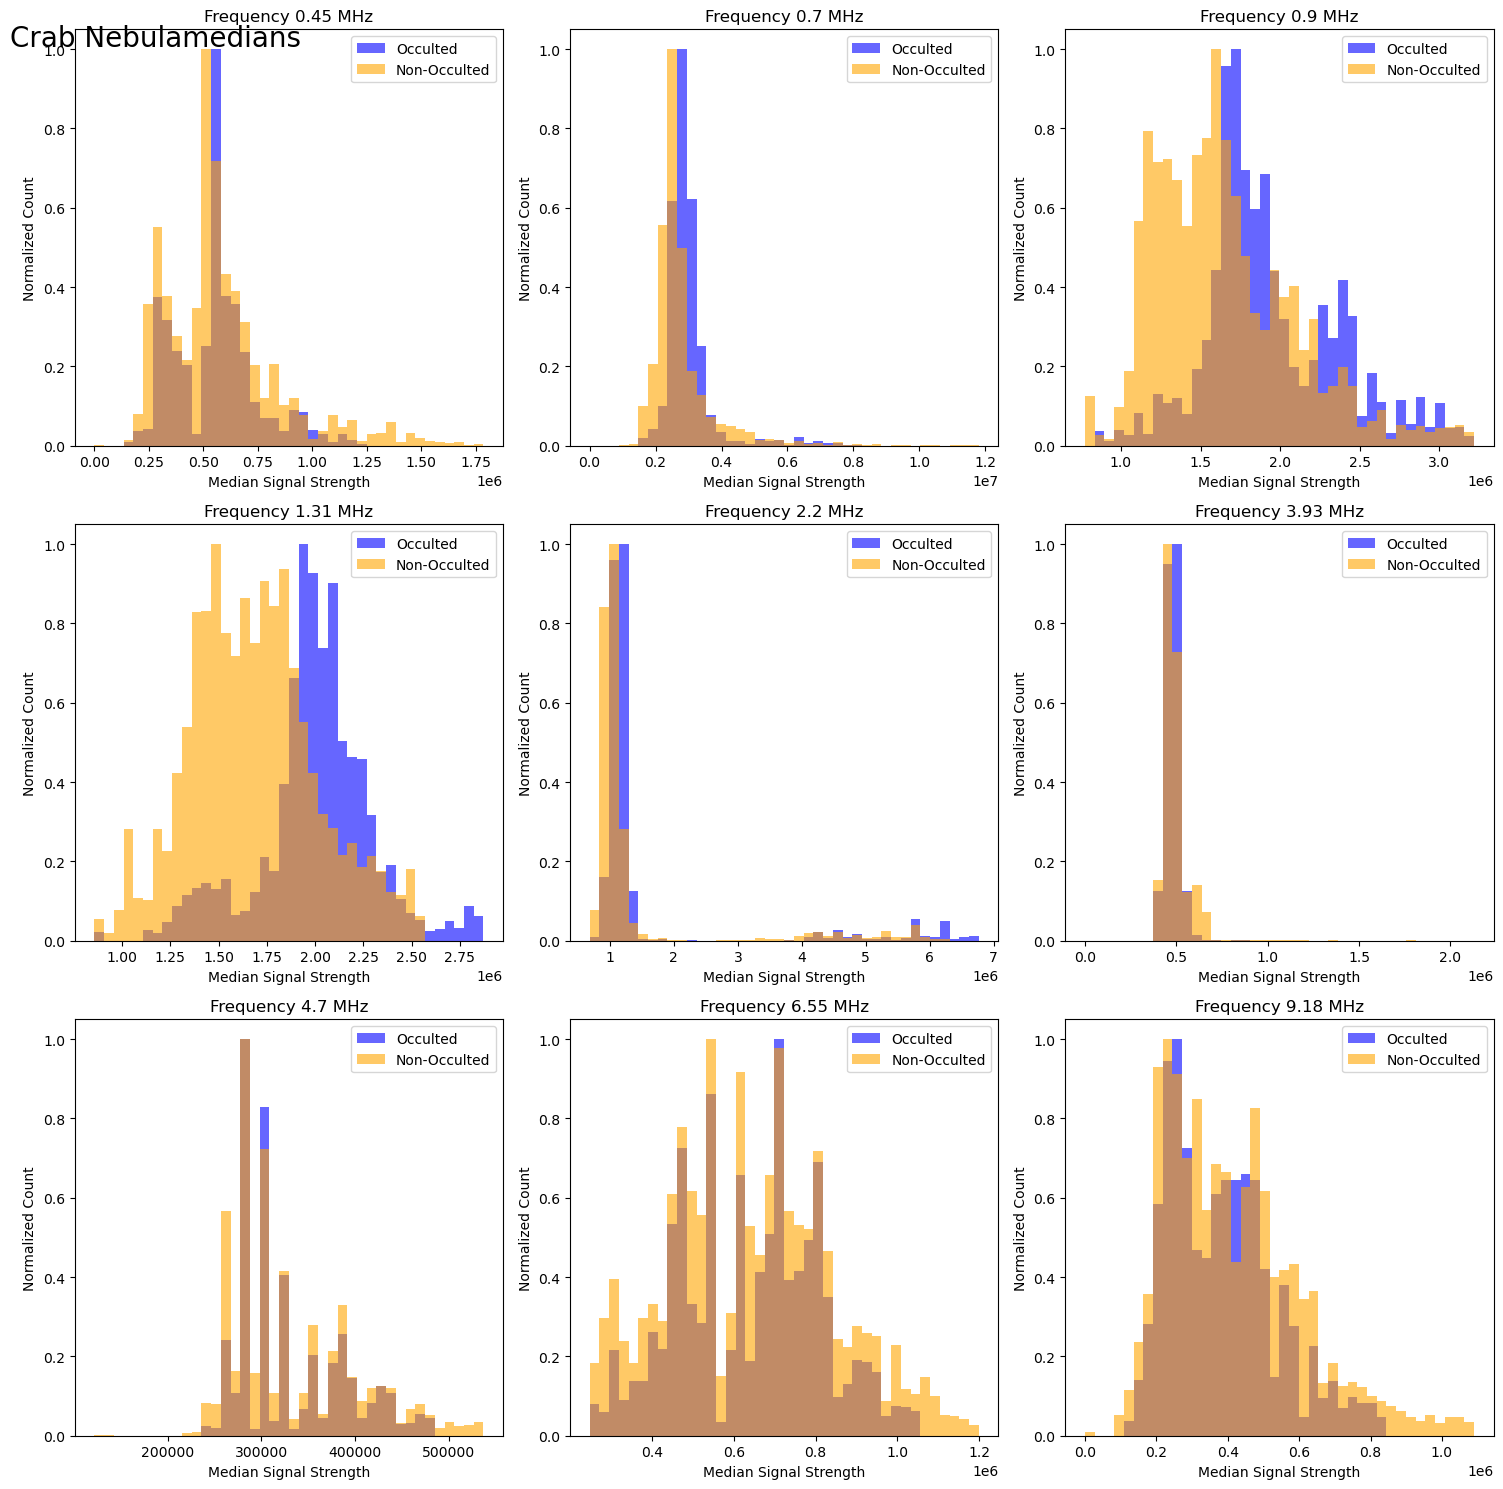

Saved histogram for Crab Nebulamedians as occultationResultsLowerV2min/histograms/Crab Nebulamedians.pdf
Figure saved as occultationResultsLowerV2min/histograms/Jupitermedians.pdf


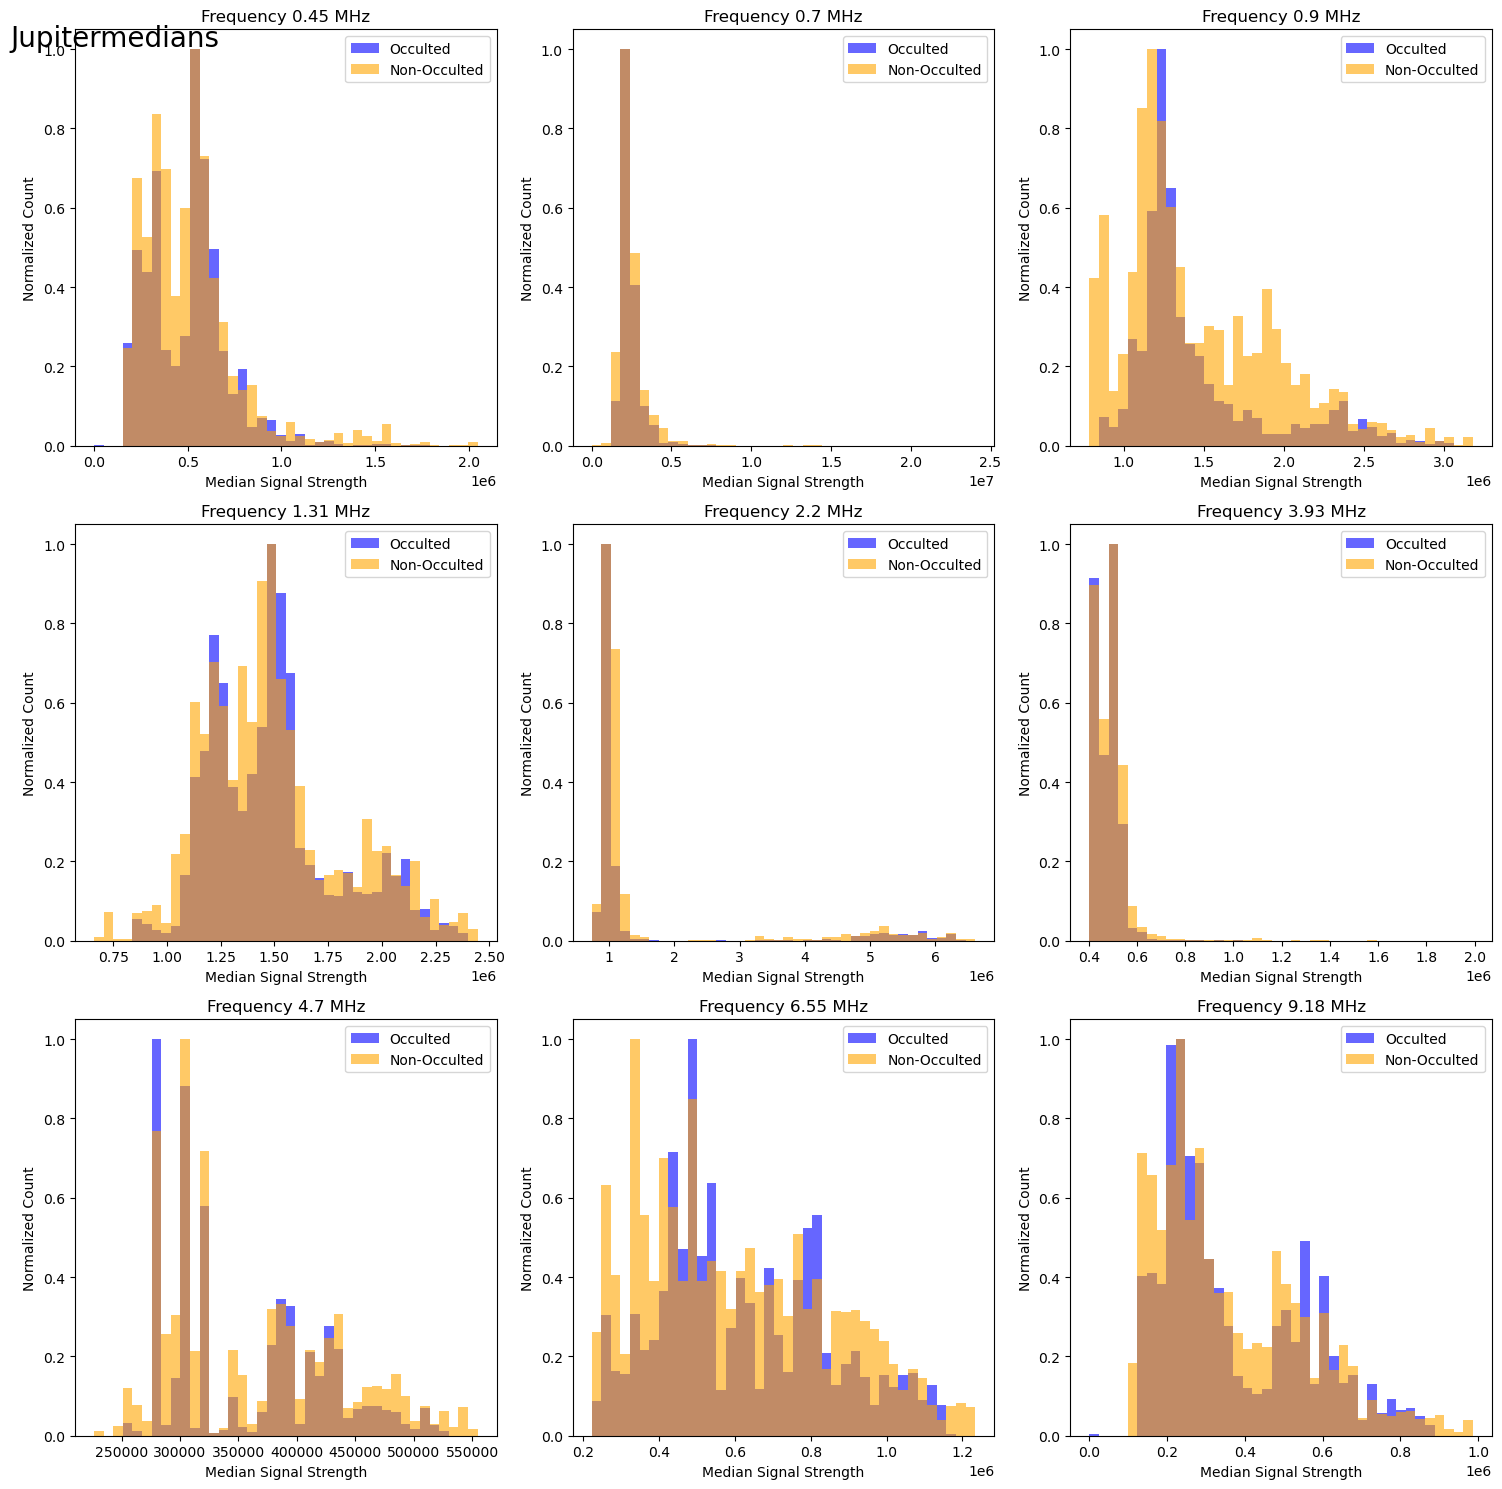

Saved histogram for Jupitermedians as occultationResultsLowerV2min/histograms/Jupitermedians.pdf
Figure saved as occultationResultsLowerV2min/histograms/Uranusmedians.pdf


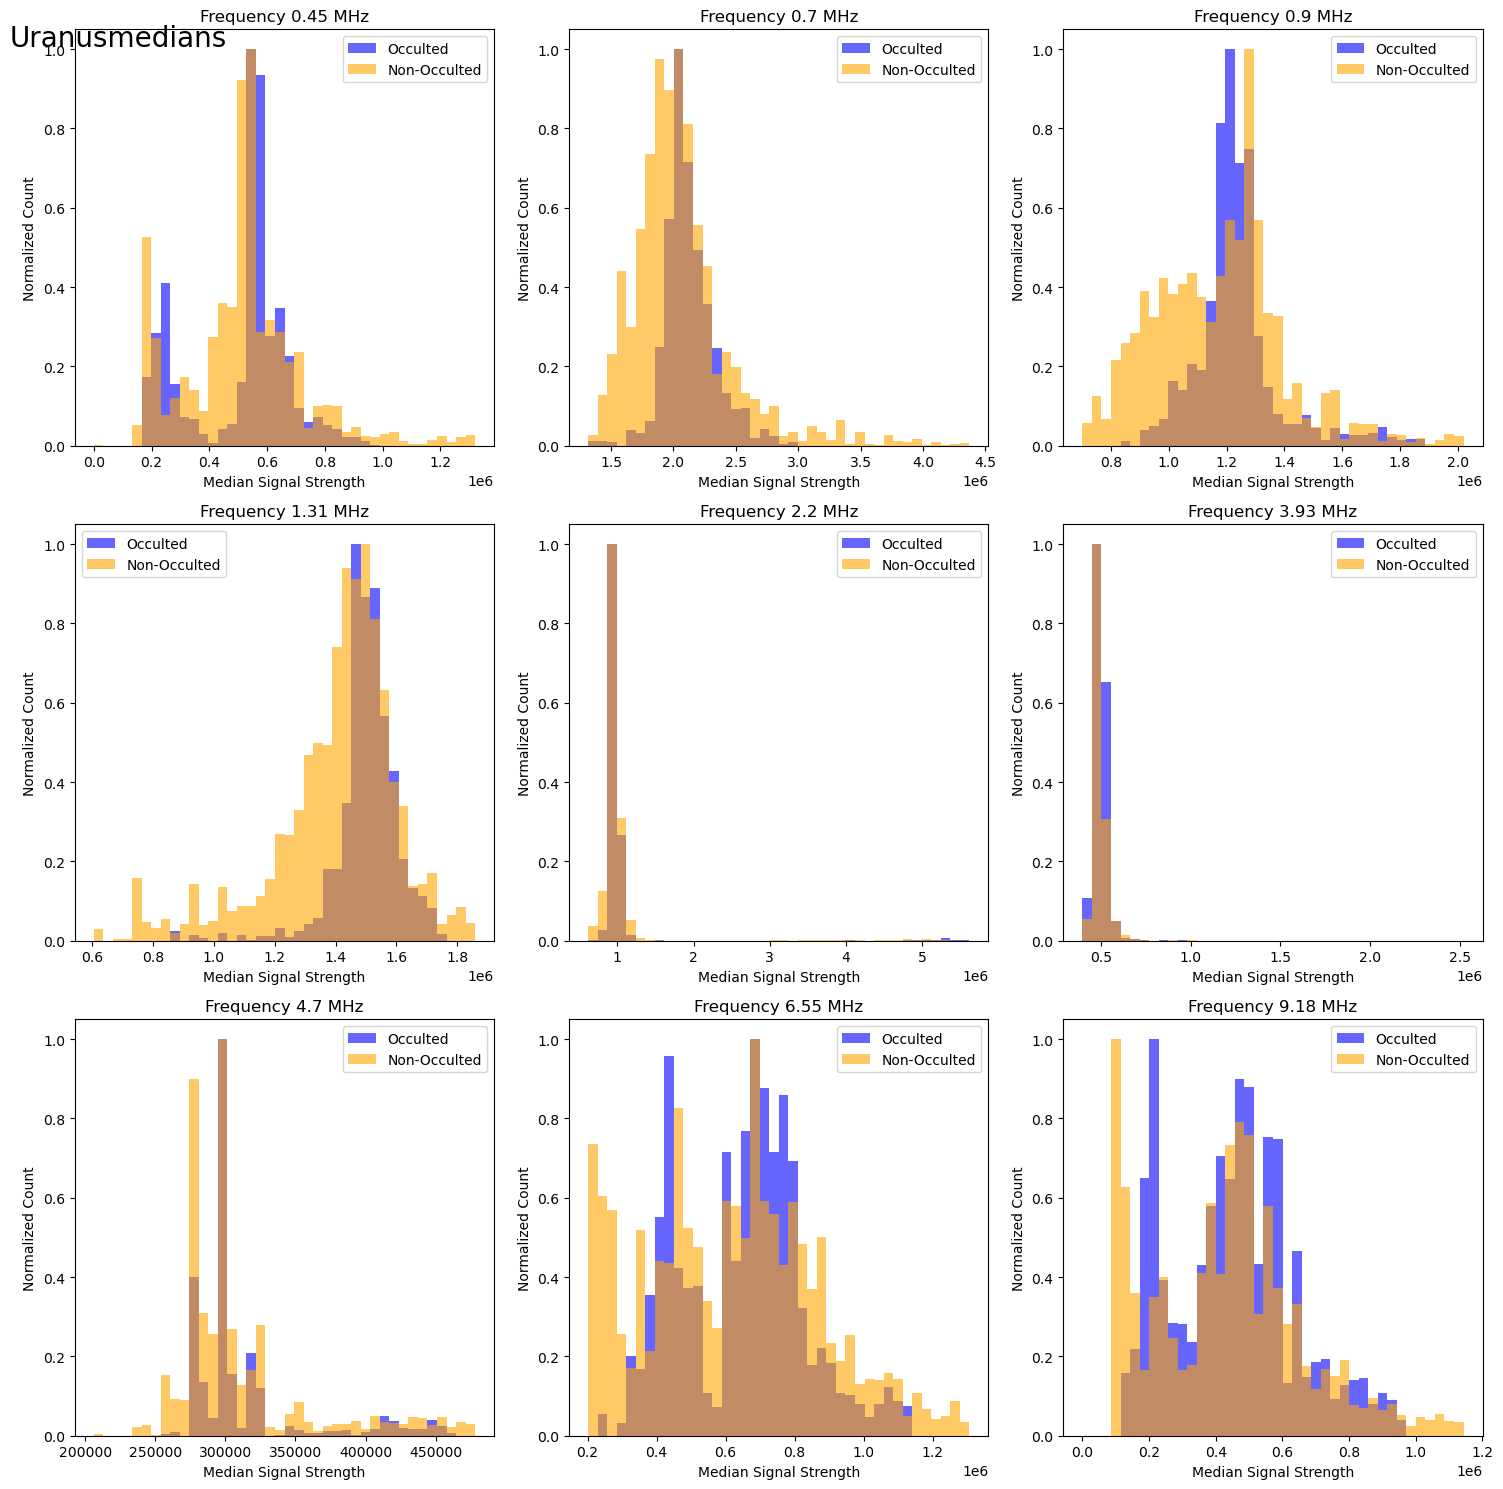

Saved histogram for Uranusmedians as occultationResultsLowerV2min/histograms/Uranusmedians.pdf


In [46]:
for pickle_file in pickle_files:
    # Extract the source name from the filename (removing the directory and extension)
    source_name = os.path.splitext(os.path.basename(pickle_file))[0]

    # Load the stats dictionary
    with open(pickle_file, "rb") as f:
        stats = pickle.load(f)

    # Define the save path for the histogram
    save_path = os.path.join(output_dir, f"{source_name}.pdf")

    # Generate and save the histogram
    rae.plotNormalizedOccultationHistogramsPretty(stats,use_std_weights=True,apply_filter=True,min_bin_percentage=[0.5,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1], fig_label=source_name, save_path=save_path)

    print(f"Saved histogram for {source_name} as {save_path}")